In [51]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen 
import pandas as pd
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
import time
import requests
import scrapy
from scrapy.crawler import CrawlerProcess
import json
import numpy as np 
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression,LassoCV,Ridge
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder , StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV



# Udemy Website

# Overview

Udemy, founded in May 2010, is an American online learning platform aimed at professional adults and students. As of Jan 2020, the platform has more than 50 million students and 57,000 instructors teaching courses in over 65 languages Students take courses largely as a means of improving job-related skills. Some courses generate credit toward technical certification. Udemy has made a special effort to attract corporate trainers seeking to create coursework for employees of their company. As of 2020, there are more than 150,000 courses on the website.

# Dataset
The dataset was collected by using web scraping methods like selenium and beautiful soup to collect more than 5K useful records from Udmey website.

This dataset contains 9899 records of courses from 4 Levels (Beginner, Intermediate, Expert and some of them suitable for All Levels) taken from Udemy. Udemy is a massive online open course (MOOC) platform that offers both free and paid courses. Anybody can create a course, a business model by which allowed Udemy to have hundreds of thousands of courses.

# Objective

The objective is to analyze dataset based on several variables, determine what variables affect Courses Subscribers the most, then build a model that can predict the Subscribers of a courses.

# Goals
Predict the Subscribers of Courses based on the features available.

# Phase I - scraping

# Inputting the URL and scraping Method 

In [ ]:
#url = 'https://www.udemy.com/robots.txt'
#response  = requests.get(url)
#print(response.text)

In [ ]:
ch='/Users/elyasm/Downloads/chromedriver'
de=15


In [ ]:
driver=webdriver.Chrome(executable_path=ch)
driver.get('https://www.udemy.com/courses/it-and-software/?p=1')

In [ ]:
def extract_text(soup_obj, tag, attribute_name, attribute_value):
    txt = soup_obj.find(tag, {attribute_name: attribute_value}).text.strip() if soup_obj.find(tag, {attribute_name: attribute_value}) else ''
    return txt

rows = []

for page_number in range(151, 625):
   #f'https://www.udemy.com/courses/it-and-software/?p={page_number}'
    page_url =f'https://www.udemy.com/courses/it-and-software/?has_closed_caption=true&p={page_number}&sort=popularity'
    driver.get(page_url)
    time.sleep(7)

    try:
        WebDriverWait(driver, de).until(EC.presence_of_element_located((By.CLASS_NAME, 'course-list--container--3zXPS')))
    except TimeoutException:
        print('Loading exceeds delay time')
        break
    else:
        soup = bs(driver.page_source, 'html.parser')
        course_list = soup.find('div', {'class': 'course-list--container--3zXPS'})
        courses = course_list.find_all('a', {'class': 'udlite-custom-focus-visible browse-course-card--link--3KIkQ'})
        
        for course in courses:          
            course_url = '{0}{1}'.format('https://www.udemy.com', course['href'])
            course_title = course.select('div[class*="course-card--course-title"]')[0].text         
            course_headline = extract_text(course, 'p', 'data-purpose', 'safely-set-inner-html:course-card:course-headline')            
            author = extract_text(course, 'div', 'data-purpose', 'safely-set-inner-html:course-card:visible-instructors')
            off_price=extract_text(course,'div', 'data-purpose', 'course-price-text').strip('Current price$')
            orig_price=extract_text(course,'div', 'data-purpose', 'original-price-container').strip('Original Price$')
            course_rating = extract_text(course, 'span', 'data-purpose', 'rating-number')
            number_of_ratings = extract_text(course, 'span', 'class', 'udlite-text-xs course-card--reviews-text--1yloi')[1:-1].replace(',','')
            course_detail = course.find_all('span', {'class':'course-card--row--29Y0w'})
            course_length = course_detail[0].get_text(strip=True).strip(' total hours')
            number_of_lectures = course_detail[1].get_text(strip=True).strip(' lectures')
            difficulity = course_detail[2].get_text(strip=True)
            r=requests.get(course_url)
            s=bs(r.content,'lxml')
            student=extract_text(s, 'div', 'data-purpose', 'enrollment').strip('student').replace(',','')

            rows.append(
                [course_url, course_title, course_headline, author,off_price,orig_price, course_rating, number_of_ratings, course_length, number_of_lectures, difficulity,student]               
            )

columns = ['url', 'Course Title', 'Course Headline', 'Instructor','off_price','orig_price', 'Rating', 'Number of Ratings', 'Course Length', 'Number of Lectures', 'Difficulity','Subscribers']
df = pd.DataFrame(data=rows, columns=columns)
df.to_csv('Udmey Courses1.csv', index=False)
driver.quit()

# Phase II - EDA

In [52]:
df1=pd.read_csv("Udemy Courses.csv")
df=pd.read_csv("Udemy Courses1.csv")
udemy=pd.concat([df1, df], join="outer")


# Amount of dataset

In [53]:
print("There are {} rows and {} columns in the dataset.".format(udemy.shape[0], udemy.shape[1]))

There are 9899 rows and 12 columns in the dataset.


Check for null values and data type:

In [126]:
udemy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9899 entries, 0 to 7514
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url                 9897 non-null   object 
 1   Course Title        9897 non-null   object 
 2   Course Headline     9897 non-null   object 
 3   Instructor          9897 non-null   object 
 4   off_price           9899 non-null   float64
 5   orig_price          9899 non-null   float64
 6   Rating              9899 non-null   float64
 7   Number of Ratings   9899 non-null   float64
 8   Course Length       9899 non-null   float64
 9   Number of Lectures  9899 non-null   float64
 10  Difficulity         9897 non-null   object 
 11  Subscribers         9899 non-null   float64
dtypes: float64(7), object(5)
memory usage: 1.2+ MB


In [55]:
udemy.isna().sum()

url                      2
Course Title             2
Course Headline          2
Instructor               2
off_price                2
orig_price            1403
Rating                 605
Number of Ratings      605
Course Length            2
Number of Lectures       2
Difficulity              2
Subscribers              2
dtype: int64

Data Cleaning:

In [56]:
udemy['Course Length']=udemy['Course Length'].str.strip(' total min').astype(np.float)
udemy['off_price']=udemy['off_price'].replace('F',None).astype(np.float)


<ipython-input-56-f6371f0c9ca8>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  udemy['Course Length']=udemy['Course Length'].str.strip(' total min').astype(np.float)
<ipython-input-56-f6371f0c9ca8>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  udemy['off_price']=udemy['off_price'].replace('F',None).astype(np.float)


Fill Nane Value with mean:

In [57]:
for column in ['orig_price','off_price','Rating','Number of Ratings','Subscribers','Course Length','Number of Lectures']:
    udemy[column]=udemy[column].fillna(udemy[column].mean())

In [58]:
for col in udemy.Subscribers:
    val = udemy['Subscribers'].mean()
    udemy['Subscribers'] = udemy['Subscribers'].replace(0, val)

In [59]:
udemy.isna().sum()

url                   2
Course Title          2
Course Headline       2
Instructor            2
off_price             0
orig_price            0
Rating                0
Number of Ratings     0
Course Length         0
Number of Lectures    0
Difficulity           2
Subscribers           0
dtype: int64

# Statistical Summary

In [60]:
udemy.describe()

off_price   orig_price       Rating  Number of Ratings  \
count  9899.000000  9899.000000  9899.000000        9899.000000   
mean     17.237247    52.726582     4.198687         454.796643   
std      14.978303    28.871697     0.508410        2435.455657   
min      14.990000    19.990000     1.000000           1.000000   
25%      14.990000    19.990000     4.000000          15.000000   
50%      14.990000    52.726582     4.300000          55.000000   
75%      14.990000    89.990000     4.500000         283.500000   
max     199.990000   129.990000     5.000000       98625.000000   

       Course Length  Number of Lectures    Subscribers  
count    9899.000000         9899.000000    9899.000000  
mean        7.616854           47.215823    6101.579840  
std        10.205088           58.518753   18845.434651  
min         1.000000            4.000000       1.000000  
25%         2.000000           16.000000     103.000000  
50%         3.500000           29.000000     823.000000  
75%         8.000000           56.000000    4948.000000  
max       125.500000          699.000000  471846.000000

In [61]:
udemy.min()

off_price             14.99
orig_price            19.99
Rating                 1.00
Number of Ratings      1.00
Course Length          1.00
Number of Lectures     4.00
Subscribers            1.00
dtype: float64

In [62]:
from pandas_profiling import ProfileReport 
report = ProfileReport(udemy)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Features in the DataFrame:

course_title: Title of course
    
url: Course URL
    
price: Price of course
    
num_subscribers: Number of subscribers for the course
    
num_lectures: Number of lectures in the course
    
Difficulity: Difficulty level of the course
    
content_duration: Duration of all course materials

<ipython-input-63-33930f06c4cb>:3: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


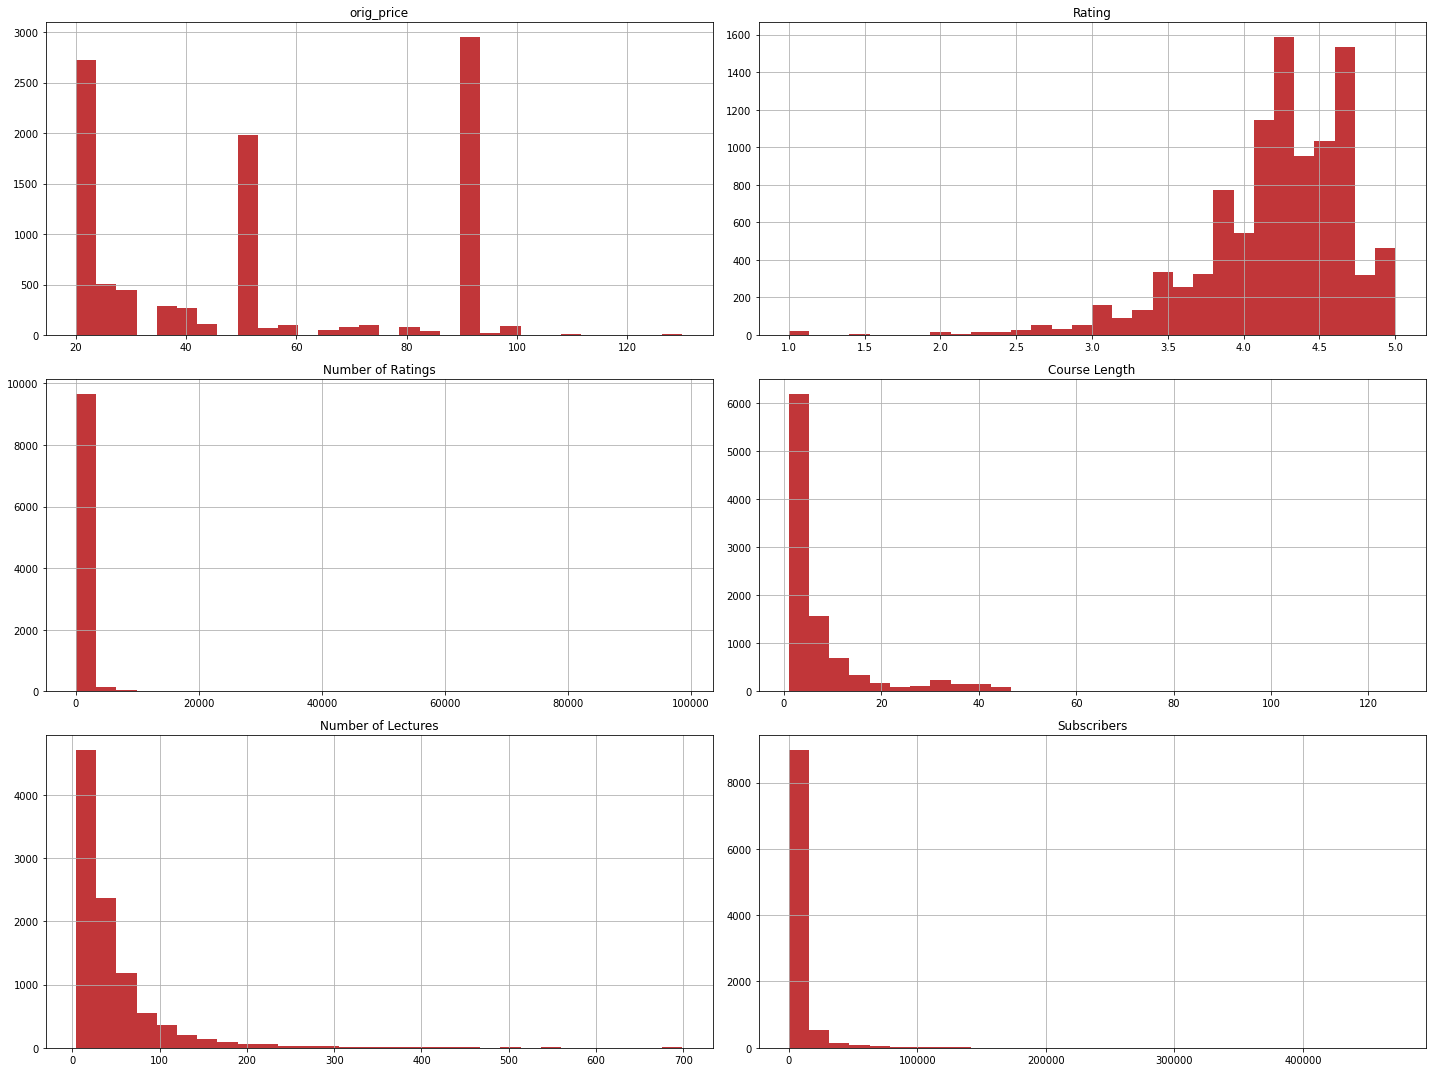

In [63]:
udemy.drop(["off_price",], axis=1).hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

Initial observations from the histograms:

Most course durations are between 0-60 min.

There are usually around 1-50 lectures per course.

Courses tend to have few reviews. There are probably a handful of courses with a large amount of reviews since the X axis goes up to 10000 while over 9000 instances are represented in the first bin.

The majority of courses are in the same range of subscribers. The instances farther up the scale were probably more successful or perhaps courses on a trending topic.

Assuming the prices are in USD, the range is between 0-120 dollars. The plot shows the most common price roughly 20 / 55 / 95 USD.

# Exploring Attribute Combinations

In [64]:
df2 = udemy

In [65]:
df2.head()

url  \
0  https://www.udemy.com/course/learn-ethical-hac...   
1  https://www.udemy.com/course/aws-certified-sol...   
2  https://www.udemy.com/course/aws-certified-clo...   
3  https://www.udemy.com/course/new-comptia-a-201...   
4  https://www.udemy.com/course/aws-certified-dev...   

                                        Course Title  \
0                 Learn Ethical Hacking From Scratch   
1  Ultimate AWS Certified Solutions Architect Ass...   
2  [NEW] Ultimate AWS Certified Cloud Practitione...   
3        TOTAL: CompTIA A+ Certification (220-1001).   
4  Ultimate AWS Certified Developer Associate 202...   

                                     Course Headline  \
0  Become an ethical hacker that can hack compute...   
1  Pass the AWS Certified Solutions Architect Ass...   
2  Pass the Amazon Web Services Certified Cloud P...   
3  Course 1: Everything you need to pass the A+ C...   
4  Become an AWS Certified Developer! Learn all A...   

                                          Instructor  off_price  orig_price  \
0                             Zaid Sabih, z Security      17.99       99.99   
1  Stephane Maarek | AWS Certified Cloud Practiti...      15.99       89.99   
2  Stephane Maarek | AWS Certified Cloud Practiti...      14.99       84.99   
3  Total Seminars • 750,000+ Enrollments, Mike Me...      20.99      119.99   
4  Stephane Maarek | AWS Certified Cloud Practiti...      14.99       89.99   

   Rating  Number of Ratings  Course Length  Number of Lectures Difficulity  \
0     4.6            98625.0           15.5               143.0  All Levels   
1     4.7            95400.0           27.0               368.0  All Levels   
2     4.7            61370.0           14.0               252.0    Beginner   
3     4.7            48413.0           17.5               131.0    Beginner   
4     4.7            47350.0           32.5               428.0  All Levels   

   Subscribers  
0     459448.0  
1     399272.0  
2     289608.0  
3     116933.0  
4     252455.0

In [66]:
corr_matrix = df2.corr()
corr_matrix["Subscribers"].sort_values(ascending=False)

Subscribers           1.000000
Number of Ratings     0.661936
Number of Lectures    0.155057
orig_price            0.089366
Course Length         0.083592
Rating                0.073222
off_price            -0.031310
Name: Subscribers, dtype: float64

<ipython-input-67-0d0b589bbb09>:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


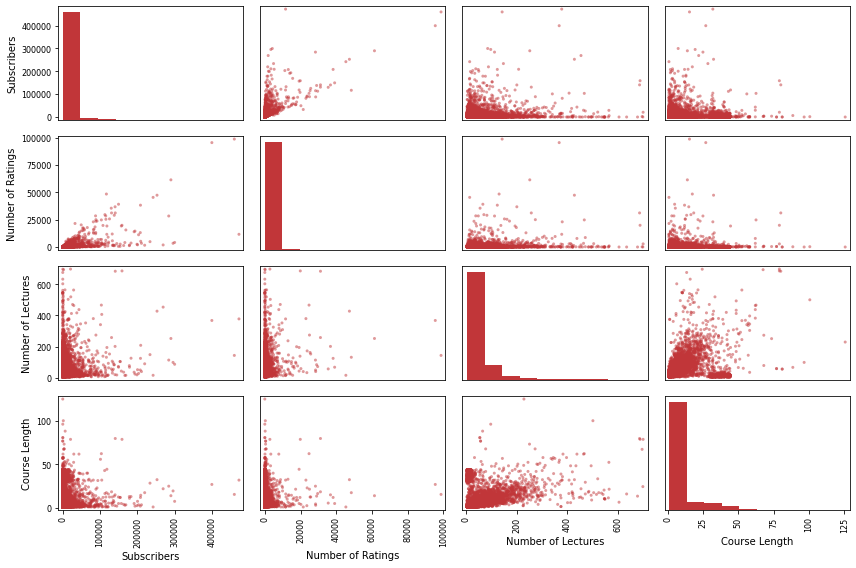

In [67]:
attributes = ["Subscribers", "Number of Ratings", "Number of Lectures", "Course Length"]

scatter_matrix(df2[attributes], figsize=(12,8))
plt.tight_layout()
plt.show()

<ipython-input-68-69c7c50c28b2>:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


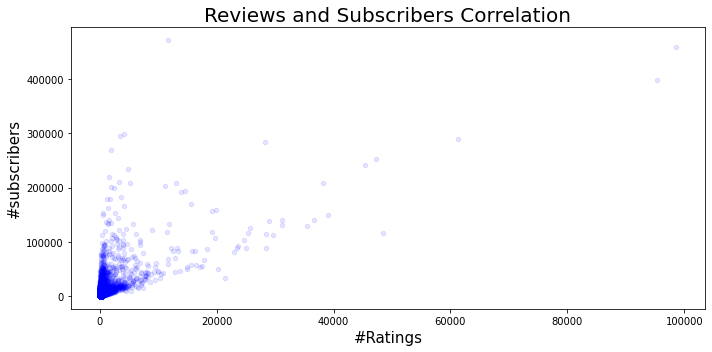

In [68]:
# scatter plot of the strongest correlation in the corr matrix
# the alpha is set to show the distribution more clearly
df2.plot(kind="scatter", x="Number of Ratings", y="Subscribers", alpha=0.1,
         color='b', figsize=(10,5))
plt.title("Reviews and Subscribers Correlation", size=20)
plt.xlabel("#Ratings", size=15)
plt.ylabel("#subscribers", size=15)
plt.tight_layout()
plt.show()

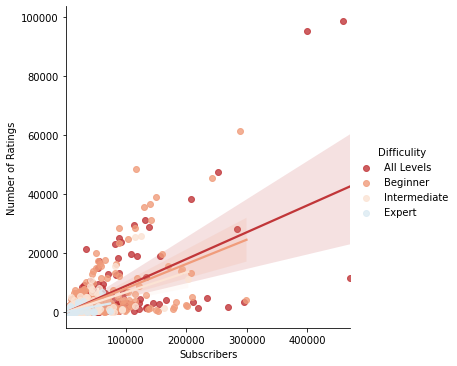

In [69]:
sns.lmplot(x = "Subscribers",y="Number of Ratings", hue = "Difficulity", data=df2);







# Correlations with num_subscribers Attribute- Overview:

The strongest positive correlations (0.1 or more) are:

*Number of Ratings

*Number of Lectures

*Course Length 

The strongest negative correlations (-0.1 or less) are:

*off_price 

<ipython-input-70-2af467d089fe>:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


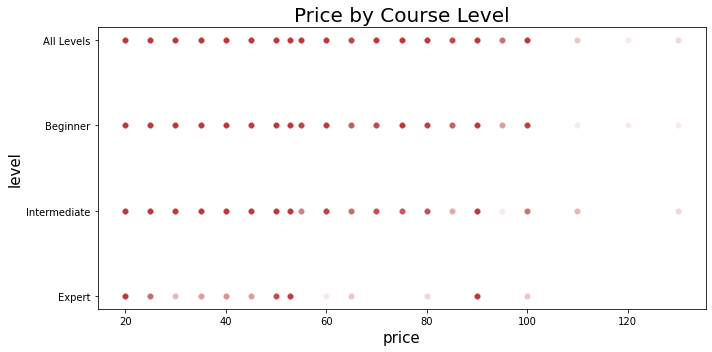

In [70]:
plt.figure(figsize=(10,5))
sns.scatterplot(y=df2["Difficulity"], x=df2["orig_price"], alpha=0.1)
plt.title("Price by Course Level", size=20)
plt.xlabel("price", size=15)
plt.ylabel("level", size=15)
plt.tight_layout()
plt.show()

<ipython-input-71-83576143f487>:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


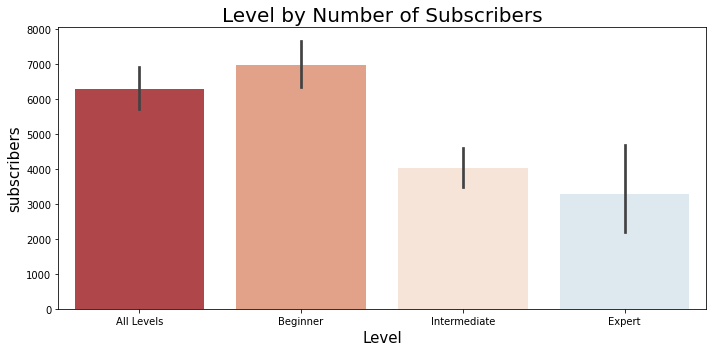

In [71]:
# plot subject by number of subscribers and level
# the black bars represent the error
plt.figure(figsize=(10,5))
sns.barplot(x=df2["Difficulity"], y=df2["Subscribers"])
plt.title("Level by Number of Subscribers", size=20)
plt.xlabel("Level", size=15)
plt.ylabel("subscribers", size=15)
plt.tight_layout()
plt.show()

<ipython-input-72-2f0dae9898fe>:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


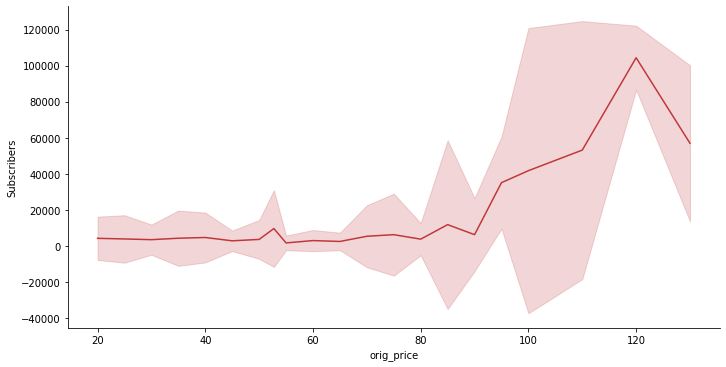

In [72]:
sns.relplot(x="orig_price", y="Subscribers", data=df2, kind="line", aspect=2, ci="sd")
plt.show()

/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='orig_price', ylabel='Density'>

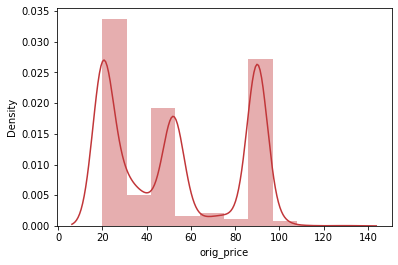

In [73]:
sns.distplot(df2.orig_price, bins=10)

<AxesSubplot:xlabel='orig_price', ylabel='Density'>

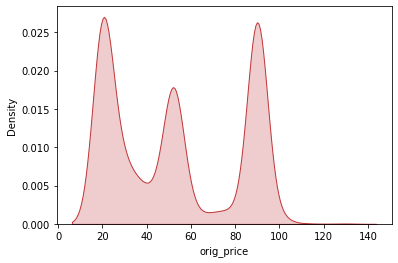

In [74]:
sns.kdeplot(df2.orig_price, shade = True)

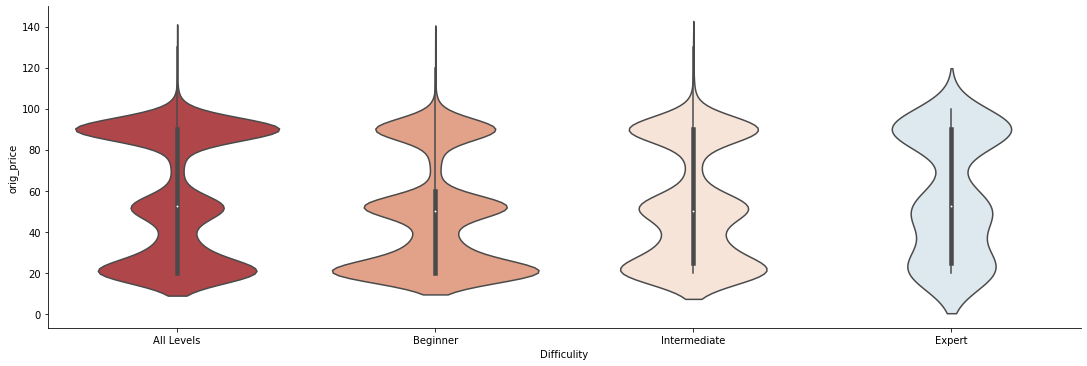

In [75]:
sns.catplot(x = "Difficulity", y = "orig_price", kind="violin", aspect=3, data = df2);




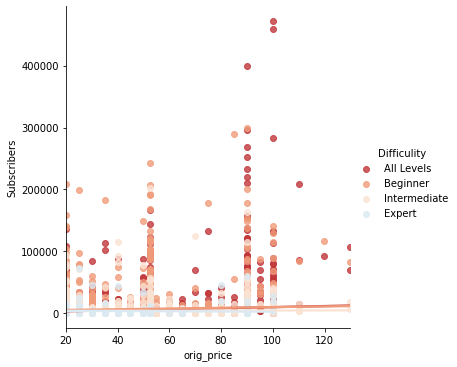

In [76]:
sns.lmplot(x = "orig_price", y = "Subscribers", hue = "Difficulity", data=df2);






<ipython-input-77-8f8514395fef>:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


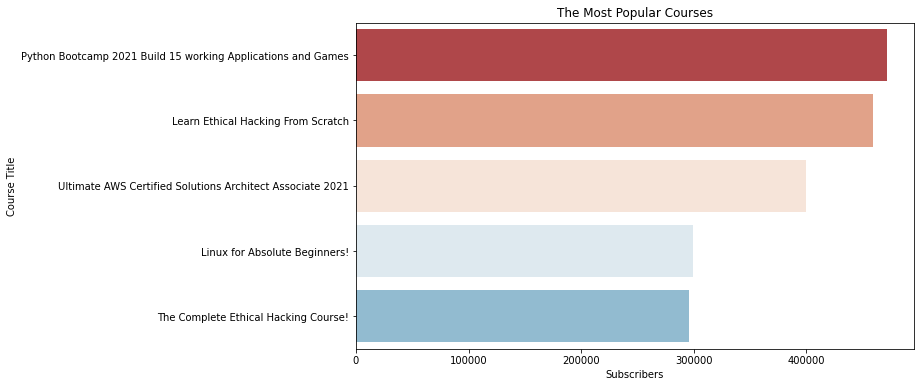

In [77]:
#Top 30 Most Popular Courses by num_subscribers
top_course = df2.sort_values(by='Subscribers', ascending=False)[:5]
figure = plt.figure(figsize=(10,6))
sns.barplot(y=top_course['Course Title'], x=top_course.Subscribers)
plt.xticks()
plt.xlabel('Subscribers')
plt.ylabel('Course Title')
plt.title('The Most Popular Courses')
plt.show()

# heatmap

<ipython-input-78-bab242455582>:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


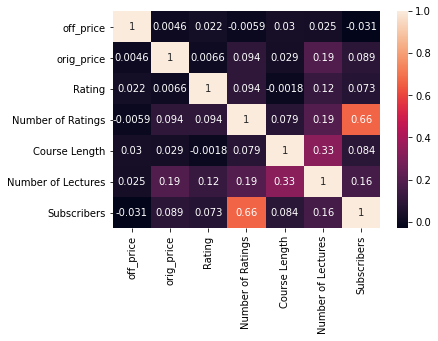

In [78]:
sns.set_palette("RdBu")
correlation=df2.corr()
sns.heatmap(correlation, annot=True)
plt.show()

# Observations:
*All Levels and Beginners are the most common level, representing over 50%.

*Price variations according to the level of the course also show that Expert is the least common level in the data. It is also the only level that does not provide free courses. The other levels are dispersed more frequently throughout the line.



In [79]:
df2.shape

(9899, 12)

# Label Encoding

In [80]:
le = LabelEncoder()
le.fit(df2["Difficulity"])
list(le.classes_)

['All Levels', 'Beginner', 'Expert', 'Intermediate', nan]

In [81]:
pd.get_dummies(df2["Difficulity"])


All Levels  Beginner  Expert  Intermediate
0              1         0       0             0
1              1         0       0             0
2              0         1       0             0
3              0         1       0             0
4              1         0       0             0
...          ...       ...     ...           ...
7510           0         0       0             1
7511           0         1       0             0
7512           0         1       0             0
7513           0         1       0             0
7514           0         1       0             0

[9899 rows x 4 columns]

# Modelling

Reviews prediction by subscribers

preparing data for train test split

Linear regression
Lasso Regression
Ridge Regression



Splitting the Data:

Before further analysis let's split the data into a training set and a testing set. This will ensure avoidance of bias that could occur from learning the data as a whole.

In [82]:
#sns.pairplot(df2)
X=pd.get_dummies(df2, columns=['Difficulity'])
X=X.drop(columns=['url','Course Title','Course Headline','Instructor','off_price','Rating','Subscribers'],axis=1)
y=df2['Subscribers']


In [83]:
print(X.shape)
print(y.shape)

(9899, 8)
(9899,)


In [84]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Baseline Model

Linear Regression

In [85]:
reg = LinearRegression()
reg.fit(X_train,y_train)
train_pre = reg.predict(X_train)
preds = reg.predict(X_test)
print("Accuracy on Traing set   : ",reg.score(X_train,y_train))
print("Accuracy on Testing set  : ",reg.score(X_test,y_test))
print("__________________________________________")
print("\t\tError Table")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, preds))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, preds))
print('Root Mean Squared Error  : ', np.sqrt(metrics.mean_squared_error(y_test, preds)))
print('R Squared Error          : ', metrics.r2_score(y_test, preds))

Accuracy on Traing set   :  0.421879766220966
Accuracy on Testing set  :  0.4920196767585796
__________________________________________
		Error Table
Mean Absolute Error      :  6028.765450802256
Mean Squared  Error      :  224538896.62211445
Root Mean Squared Error  :  14984.622004645778
R Squared Error          :  0.4920196767585796


<ipython-input-86-bb19bcdccd01>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


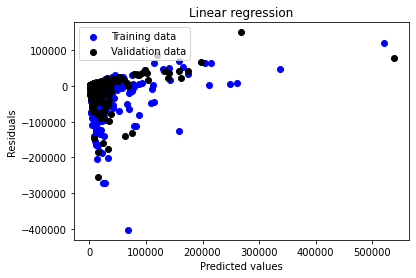

In [86]:
plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
plt.scatter(preds,preds - y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Polynomial Features

In [87]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_test_poly = poly.transform(X_test)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
y_pred0=lr_poly.predict(X_test_poly)
print("Accuracy on Traing set   : ",lr_poly.score(X_train_poly,y_train))
print("Accuracy on Testing set  : ",lr_poly.score(X_test_poly,y_test))
print("__________________________________________")
print("\t\tError Table")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred0))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred0))
print('Root Mean Squared Error  : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred0)))
print('R Squared Error          : ', metrics.r2_score(y_test, y_pred0))

Accuracy on Traing set   :  0.4578203338885679
Accuracy on Testing set  :  0.5020747314870302
__________________________________________
		Error Table
Mean Absolute Error      :  5865.699410217118
Mean Squared  Error      :  220094332.94335902
Root Mean Squared Error  :  14835.576596255334
R Squared Error          :  0.5020747314870302


In [88]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train_poly)
X_test_scaled = std.transform(X_test_poly)

In [89]:
m = LinearRegression()
m.fit(X_train_scaled,y_train)
y_pred2=m.predict(X_test_scaled)

print("Accuracy on Testing set  : ",m.score(X_test_scaled,y_test))
print("__________________________________________")
print("\t\tError Table")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error  : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('R Squared Error          : ', metrics.r2_score(y_test, y_pred2))

Accuracy on Testing set  :  0.5020773476304028
__________________________________________
		Error Table
Mean Absolute Error      :  5866.0009941150065
Mean Squared  Error      :  220093176.54827952
Root Mean Squared Error  :  14835.537622488762
R Squared Error          :  0.5020773476304028


# Lasso


In [115]:
lasso_reg=linear_model.Lasso(alpha=202)
lasso_reg.fit(X_train,y_train)
y_pred=lasso_reg.predict(X_test)

print("Accuracy on Traing set   : ",lasso_reg.score(X_train,y_train))
print("Accuracy on Testing set  : ",lasso_reg.score(X_test,y_test))
print("__________________________________________")
print("\t\tError Table")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error  : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared Error          : ', metrics.r2_score(y_test, y_pred))

Accuracy on Traing set   :  0.4206469684230171
Accuracy on Testing set  :  0.49039110199582914
__________________________________________
		Error Table
Mean Absolute Error      :  6055.117194773522
Mean Squared  Error      :  225258763.83657902
Root Mean Squared Error  :  15008.622982691617
R Squared Error          :  0.49039110199582914


# GridSearchCV: Lasso

In [116]:
alphas = np.linspace(0.001, 1,100)
kf = KFold(5, random_state=42, shuffle=True )

In [117]:
params = {'alpha':alphas}
gs = GridSearchCV(linear_model.Lasso(), param_grid=params,verbose=100, cv=kf)
model = gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START alpha=0.001...............................................
[CV 1/5; 1/100] END .............................alpha=0.001; total time=   0.2s
[CV 2/5; 1/100] START alpha=0.001...............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419237613912.1455, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517745428446.1001, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 1/100] END .............................alpha=0.001; total time=   0.2s
[CV 3/5; 1/100] START alpha=0.001...............................................
[CV 3/5; 1/100] END .............................alpha=0.001; total time=   0.2s
[CV 4/5; 1/100] START alpha=0.001...............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465434982395.441, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 473847072241.5002, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 1/100] END .............................alpha=0.001; total time=   0.2s
[CV 5/5; 1/100] START alpha=0.001...............................................
[CV 5/5; 1/100] END .............................alpha=0.001; total time=   0.2s
[CV 1/5; 2/100] START alpha=0.011090909090909092................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 555515741523.3644, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245080907928.15845, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 2/100] END ..............alpha=0.011090909090909092; total time=   0.2s
[CV 2/5; 2/100] START alpha=0.011090909090909092................................
[CV 2/5; 2/100] END ..............alpha=0.011090909090909092; total time=   0.2s
[CV 3/5; 2/100] START alpha=0.011090909090909092................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338311617314.1388, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252368421770.95636, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 2/100] END ..............alpha=0.011090909090909092; total time=   0.2s
[CV 4/5; 2/100] START alpha=0.011090909090909092................................
[CV 4/5; 2/100] END ..............alpha=0.011090909090909092; total time=   0.2s
[CV 5/5; 2/100] START alpha=0.011090909090909092................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260960190228.86407, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287065712471.84973, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 2/100] END ..............alpha=0.011090909090909092; total time=   0.2s
[CV 1/5; 3/100] START alpha=0.021181818181818184................................
[CV 1/5; 3/100] END ..............alpha=0.021181818181818184; total time=   0.2s
[CV 2/5; 3/100] START alpha=0.021181818181818184................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246669231567.71008, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311780929978.0664, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 3/100] END ..............alpha=0.021181818181818184; total time=   0.2s
[CV 3/5; 3/100] START alpha=0.021181818181818184................................
[CV 3/5; 3/100] END ..............alpha=0.021181818181818184; total time=   0.2s
[CV 4/5; 3/100] START alpha=0.021181818181818184................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236775584819.50775, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206878750893.39417, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 3/100] END ..............alpha=0.021181818181818184; total time=   0.2s
[CV 5/5; 3/100] START alpha=0.021181818181818184................................
[CV 5/5; 3/100] END ..............alpha=0.021181818181818184; total time=   0.2s
[CV 1/5; 4/100] START alpha=0.03127272727272727.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256574482565.0125, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247231043323.3202, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 4/100] END ...............alpha=0.03127272727272727; total time=   0.2s
[CV 2/5; 4/100] START alpha=0.03127272727272727.................................
[CV 2/5; 4/100] END ...............alpha=0.03127272727272727; total time=   0.2s
[CV 3/5; 4/100] START alpha=0.03127272727272727.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300784628306.435, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230908504010.35828, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209604870628.2851, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 4/100] END ...............alpha=0.03127272727272727; total time=   0.2s
[CV 4/5; 4/100] START alpha=0.03127272727272727.................................
[CV 4/5; 4/100] END ...............alpha=0.03127272727272727; total time=   0.2s
[CV 5/5; 4/100] START alpha=0.03127272727272727.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 258033471484.15363, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247519276694.99017, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 4/100] END ...............alpha=0.03127272727272727; total time=   0.2s
[CV 1/5; 5/100] START alpha=0.041363636363636366................................
[CV 1/5; 5/100] END ..............alpha=0.041363636363636366; total time=   0.2s
[CV 2/5; 5/100] START alpha=0.041363636363636366................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294782515378.4936, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222022735782.5739, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 5/100] END ..............alpha=0.041363636363636366; total time=   0.2s
[CV 3/5; 5/100] START alpha=0.041363636363636366................................
[CV 3/5; 5/100] END ..............alpha=0.041363636363636366; total time=   0.2s
[CV 4/5; 5/100] START alpha=0.041363636363636366................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210961585795.94037, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 258777915746.92047, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 5/100] END ..............alpha=0.041363636363636366; total time=   0.2s
[CV 5/5; 5/100] START alpha=0.041363636363636366................................
[CV 5/5; 5/100] END ..............alpha=0.041363636363636366; total time=   0.1s
[CV 1/5; 6/100] START alpha=0.05145454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240446429876.2337, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290323038026.71545, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 6/100] END ...............alpha=0.05145454545454546; total time=   0.2s
[CV 2/5; 6/100] START alpha=0.05145454545454546.................................
[CV 2/5; 6/100] END ...............alpha=0.05145454545454546; total time=   0.2s
[CV 3/5; 6/100] START alpha=0.05145454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221476465236.90088, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 211775771337.2373, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 6/100] END ...............alpha=0.05145454545454546; total time=   0.2s
[CV 4/5; 6/100] START alpha=0.05145454545454546.................................
[CV 4/5; 6/100] END ...............alpha=0.05145454545454546; total time=   0.2s
[CV 5/5; 6/100] START alpha=0.05145454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259230122514.3916, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240179753710.83258, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 6/100] END ...............alpha=0.05145454545454546; total time=   0.2s
[CV 1/5; 7/100] START alpha=0.06154545454545455.................................
[CV 1/5; 7/100] END ...............alpha=0.06154545454545455; total time=   0.2s
[CV 2/5; 7/100] START alpha=0.06154545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292378448321.0066, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221187922889.31946, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 7/100] END ...............alpha=0.06154545454545455; total time=   0.2s
[CV 3/5; 7/100] START alpha=0.06154545454545455.................................
[CV 3/5; 7/100] END ...............alpha=0.06154545454545455; total time=   0.2s
[CV 4/5; 7/100] START alpha=0.06154545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212321386095.40784, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259534399804.28613, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 7/100] END ...............alpha=0.06154545454545455; total time=   0.2s
[CV 5/5; 7/100] START alpha=0.06154545454545455.................................
[CV 5/5; 7/100] END ...............alpha=0.06154545454545455; total time=   0.1s
[CV 1/5; 8/100] START alpha=0.07163636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239965773542.45953, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291081177239.934, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 8/100] END ...............alpha=0.07163636363636364; total time=   0.2s
[CV 2/5; 8/100] START alpha=0.07163636363636364.................................
[CV 2/5; 8/100] END ...............alpha=0.07163636363636364; total time=   0.2s
[CV 3/5; 8/100] START alpha=0.07163636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220997706713.7292, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212712799875.12665, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 8/100] END ...............alpha=0.07163636363636364; total time=   0.2s
[CV 4/5; 8/100] START alpha=0.07163636363636364.................................
[CV 4/5; 8/100] END ...............alpha=0.07163636363636364; total time=   0.2s
[CV 5/5; 8/100] START alpha=0.07163636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259753461595.2965, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239811582709.164, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 8/100] END ...............alpha=0.07163636363636364; total time=   0.2s
[CV 1/5; 9/100] START alpha=0.08172727272727273.................................
[CV 1/5; 9/100] END ...............alpha=0.08172727272727273; total time=   0.2s
[CV 2/5; 9/100] START alpha=0.08172727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209110777075.56744, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220862995384.67303, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 9/100] END ...............alpha=0.08172727272727273; total time=   0.2s
[CV 3/5; 9/100] START alpha=0.08172727272727273.................................
[CV 3/5; 9/100] END ...............alpha=0.08172727272727273; total time=   0.1s
[CV 4/5; 9/100] START alpha=0.08172727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213007512070.71173, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259918957702.54956, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 9/100] END ...............alpha=0.08172727272727273; total time=   0.2s
[CV 5/5; 9/100] START alpha=0.08172727272727273.................................
[CV 5/5; 9/100] END ...............alpha=0.08172727272727273; total time=   0.1s
[CV 1/5; 10/100] START alpha=0.09181818181818183................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239695825220.41382, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208906249042.2611, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 10/100] END ..............alpha=0.09181818181818183; total time=   0.2s
[CV 2/5; 10/100] START alpha=0.09181818181818183................................
[CV 2/5; 10/100] END ..............alpha=0.09181818181818183; total time=   0.2s
[CV 3/5; 10/100] START alpha=0.09181818181818183................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220762471648.06396, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213237594286.1775, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 10/100] END ..............alpha=0.09181818181818183; total time=   0.2s
[CV 4/5; 10/100] START alpha=0.09181818181818183................................
[CV 4/5; 10/100] END ..............alpha=0.09181818181818183; total time=   0.1s
[CV 5/5; 10/100] START alpha=0.09181818181818183................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249413656983.1667, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239605495937.78564, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 10/100] END ..............alpha=0.09181818181818183; total time=   0.2s
[CV 1/5; 11/100] START alpha=0.10190909090909092................................
[CV 1/5; 11/100] END ..............alpha=0.10190909090909092; total time=   0.1s
[CV 2/5; 11/100] START alpha=0.10190909090909092................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222734510097.75006, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223384798193.08575, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 11/100] END ..............alpha=0.10190909090909092; total time=   0.2s
[CV 3/5; 11/100] START alpha=0.10190909090909092................................
[CV 3/5; 11/100] END ..............alpha=0.10190909090909092; total time=   0.2s
[CV 4/5; 11/100] START alpha=0.10190909090909092................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213422347151.57117, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249355299089.25726, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 11/100] END ..............alpha=0.10190909090909092; total time=   0.2s
[CV 5/5; 11/100] START alpha=0.10190909090909092................................
[CV 5/5; 11/100] END ..............alpha=0.10190909090909092; total time=   0.2s
[CV 1/5; 12/100] START alpha=0.112..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239532855167.847, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225776788620.8949, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 12/100] END ............................alpha=0.112; total time=   0.2s
[CV 2/5; 12/100] START alpha=0.112..............................................
[CV 2/5; 12/100] END ............................alpha=0.112; total time=   0.2s
[CV 3/5; 12/100] START alpha=0.112..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193061037619.30975, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213574081508.36633, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 12/100] END ............................alpha=0.112; total time=   0.2s
[CV 4/5; 12/100] START alpha=0.112..............................................
[CV 4/5; 12/100] END ............................alpha=0.112; total time=   0.2s
[CV 5/5; 12/100] START alpha=0.112..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249311403023.88446, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178623564986.30365, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 12/100] END ............................alpha=0.112; total time=   0.2s
[CV 1/5; 13/100] START alpha=0.1220909090909091.................................
[CV 1/5; 13/100] END ...............alpha=0.1220909090909091; total time=   0.2s
[CV 2/5; 13/100] START alpha=0.1220909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227455468071.95947, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192128919676.05017, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 13/100] END ...............alpha=0.1220909090909091; total time=   0.2s
[CV 3/5; 13/100] START alpha=0.1220909090909091.................................
[CV 3/5; 13/100] END ...............alpha=0.1220909090909091; total time=   0.2s
[CV 4/5; 13/100] START alpha=0.1220909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213701020084.17938, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249278697487.26062, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 13/100] END ...............alpha=0.1220909090909091; total time=   0.2s
[CV 5/5; 13/100] START alpha=0.1220909090909091.................................
[CV 5/5; 13/100] END ...............alpha=0.1220909090909091; total time=   0.2s
[CV 1/5; 14/100] START alpha=0.13218181818181818................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178428144695.89728, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223526337114.3565, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 14/100] END ..............alpha=0.13218181818181818; total time=   0.2s
[CV 2/5; 14/100] START alpha=0.13218181818181818................................
[CV 2/5; 14/100] END ..............alpha=0.13218181818181818; total time=   0.2s
[CV 3/5; 14/100] START alpha=0.13218181818181818................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191304202045.52576, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197236385017.3645, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 14/100] END ..............alpha=0.13218181818181818; total time=   0.2s
[CV 4/5; 14/100] START alpha=0.13218181818181818................................
[CV 4/5; 14/100] END ..............alpha=0.13218181818181818; total time=   0.2s
[CV 5/5; 14/100] START alpha=0.13218181818181818................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249253556102.60852, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181524067946.80786, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 14/100] END ..............alpha=0.13218181818181818; total time=   0.2s
[CV 1/5; 15/100] START alpha=0.14227272727272727................................
[CV 1/5; 15/100] END ..............alpha=0.14227272727272727; total time=   0.2s
[CV 2/5; 15/100] START alpha=0.14227272727272727................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221139942728.69415, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191069939056.37433, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 15/100] END ..............alpha=0.14227272727272727; total time=   0.2s
[CV 3/5; 15/100] START alpha=0.14227272727272727................................
[CV 3/5; 15/100] END ..............alpha=0.14227272727272727; total time=   0.2s
[CV 4/5; 15/100] START alpha=0.14227272727272727................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196891481242.5724, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249233680811.883, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 15/100] END ..............alpha=0.14227272727272727; total time=   0.2s
[CV 5/5; 15/100] START alpha=0.14227272727272727................................
[CV 5/5; 15/100] END ..............alpha=0.14227272727272727; total time=   0.2s
[CV 1/5; 16/100] START alpha=0.15236363636363637................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182796468203.5268, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219397770568.27917, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 16/100] END ..............alpha=0.15236363636363637; total time=   0.2s
[CV 2/5; 16/100] START alpha=0.15236363636363637................................
[CV 2/5; 16/100] END ..............alpha=0.15236363636363637; total time=   0.2s
[CV 3/5; 16/100] START alpha=0.15236363636363637................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191163321365.99255, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196926787016.44904, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 16/100] END ..............alpha=0.15236363636363637; total time=   0.2s
[CV 4/5; 16/100] START alpha=0.15236363636363637................................
[CV 4/5; 16/100] END ..............alpha=0.15236363636363637; total time=   0.2s
[CV 5/5; 16/100] START alpha=0.15236363636363637................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249112253352.88428, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183766139023.5644, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 16/100] END ..............alpha=0.15236363636363637; total time=   0.2s
[CV 1/5; 17/100] START alpha=0.16245454545454546................................
[CV 1/5; 17/100] END ..............alpha=0.16245454545454546; total time=   0.2s
[CV 2/5; 17/100] START alpha=0.16245454545454546................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218026528895.22632, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125678280203.32947, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 17/100] END ..............alpha=0.16245454545454546; total time=   0.2s
[CV 3/5; 17/100] START alpha=0.16245454545454546................................
[CV 3/5; 17/100] END ..............alpha=0.16245454545454546; total time=   0.2s
[CV 4/5; 17/100] START alpha=0.16245454545454546................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196966122069.94055, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249070950960.11993, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 17/100] END ..............alpha=0.16245454545454546; total time=   0.2s
[CV 5/5; 17/100] START alpha=0.16245454545454546................................
[CV 5/5; 17/100] END ..............alpha=0.16245454545454546; total time=   0.2s
[CV 1/5; 18/100] START alpha=0.17254545454545456................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167490854691.66956, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216926496361.36914, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 18/100] END ..............alpha=0.17254545454545456; total time=   0.2s
[CV 2/5; 18/100] START alpha=0.17254545454545456................................
[CV 2/5; 18/100] END ..............alpha=0.17254545454545456; total time=   0.2s
[CV 3/5; 18/100] START alpha=0.17254545454545456................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122829198915.078, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146582339852.67322, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 18/100] END ..............alpha=0.17254545454545456; total time=   0.2s
[CV 4/5; 18/100] START alpha=0.17254545454545456................................
[CV 4/5; 18/100] END ..............alpha=0.17254545454545456; total time=   0.2s
[CV 5/5; 18/100] START alpha=0.17254545454545456................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249045253637.47504, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166870022995.40015, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 18/100] END ..............alpha=0.17254545454545456; total time=   0.2s
[CV 1/5; 19/100] START alpha=0.18263636363636365................................
[CV 1/5; 19/100] END ..............alpha=0.18263636363636365; total time=   0.2s
[CV 2/5; 19/100] START alpha=0.18263636363636365................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216018358950.47516, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121365078626.31763, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 19/100] END ..............alpha=0.18263636363636365; total time=   0.2s
[CV 3/5; 19/100] START alpha=0.18263636363636365................................
[CV 3/5; 19/100] END ..............alpha=0.18263636363636365; total time=   0.2s
[CV 4/5; 19/100] START alpha=0.18263636363636365................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146094308619.04852, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249024279712.1396, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 19/100] END ..............alpha=0.18263636363636365; total time=   0.2s
[CV 5/5; 19/100] START alpha=0.18263636363636365................................
[CV 5/5; 19/100] END ..............alpha=0.18263636363636365; total time=   0.2s
[CV 1/5; 20/100] START alpha=0.19272727272727275................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166248346774.172, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 20/100] END ..............alpha=0.19272727272727275; total time=   0.2s
[CV 2/5; 20/100] START alpha=0.19272727272727275................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215256846612.09253, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 20/100] END ..............alpha=0.19272727272727275; total time=   0.2s
[CV 3/5; 20/100] START alpha=0.19272727272727275................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120152604915.09229, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145779285908.60968, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 20/100] END ..............alpha=0.19272727272727275; total time=   0.2s
[CV 4/5; 20/100] START alpha=0.19272727272727275................................
[CV 4/5; 20/100] END ..............alpha=0.19272727272727275; total time=   0.2s
[CV 5/5; 20/100] START alpha=0.19272727272727275................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249007109612.38007, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165694019829.48816, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 20/100] END ..............alpha=0.19272727272727275; total time=   0.2s
[CV 1/5; 21/100] START alpha=0.20281818181818184................................
[CV 1/5; 21/100] END ..............alpha=0.20281818181818184; total time=   0.2s
[CV 2/5; 21/100] START alpha=0.20281818181818184................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214618557221.10468, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119112187439.7312, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 21/100] END ..............alpha=0.20281818181818184; total time=   0.2s
[CV 3/5; 21/100] START alpha=0.20281818181818184................................
[CV 3/5; 21/100] END ..............alpha=0.20281818181818184; total time=   0.2s
[CV 4/5; 21/100] START alpha=0.20281818181818184................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145555286134.7152, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248992934244.40942, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 21/100] END ..............alpha=0.20281818181818184; total time=   0.2s
[CV 5/5; 21/100] START alpha=0.20281818181818184................................
[CV 5/5; 21/100] END ..............alpha=0.20281818181818184; total time=   0.2s
[CV 1/5; 22/100] START alpha=0.2129090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165204596466.6068, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 22/100] END ...............alpha=0.2129090909090909; total time=   0.2s
[CV 2/5; 22/100] START alpha=0.2129090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202141016315.58972, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120006824557.58167, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 22/100] END ...............alpha=0.2129090909090909; total time=   0.2s
[CV 3/5; 22/100] START alpha=0.2129090909090909.................................
[CV 3/5; 22/100] END ...............alpha=0.2129090909090909; total time=   0.2s
[CV 4/5; 22/100] START alpha=0.2129090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145394535069.5774, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248981096018.79248, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 22/100] END ...............alpha=0.2129090909090909; total time=   0.2s
[CV 5/5; 22/100] START alpha=0.2129090909090909.................................
[CV 5/5; 22/100] END ...............alpha=0.2129090909090909; total time=   0.2s
[CV 1/5; 23/100] START alpha=0.223..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164777025498.114, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188469834365.69165, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 23/100] END ............................alpha=0.223; total time=   0.2s
[CV 2/5; 23/100] START alpha=0.223..............................................
[CV 2/5; 23/100] END ............................alpha=0.223; total time=   0.2s
[CV 3/5; 23/100] START alpha=0.223..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119574233745.79602, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145277521623.66516, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 23/100] END ............................alpha=0.223; total time=   0.2s
[CV 4/5; 23/100] START alpha=0.223..............................................
[CV 4/5; 23/100] END ............................alpha=0.223; total time=   0.2s
[CV 5/5; 23/100] START alpha=0.223..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124905722043.72546, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164403204220.8506, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 23/100] END ............................alpha=0.223; total time=   0.2s
[CV 1/5; 24/100] START alpha=0.2330909090909091.................................
[CV 1/5; 24/100] END ...............alpha=0.2330909090909091; total time=   0.2s
[CV 2/5; 24/100] START alpha=0.2330909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174649768202.28394, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119193351658.21338, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 24/100] END ...............alpha=0.2330909090909091; total time=   0.2s
[CV 3/5; 24/100] START alpha=0.2330909090909091.................................
[CV 3/5; 24/100] END ...............alpha=0.2330909090909091; total time=   0.2s
[CV 4/5; 24/100] START alpha=0.2330909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145193640016.67468, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135114833101.2218, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 24/100] END ...............alpha=0.2330909090909091; total time=   0.2s
[CV 5/5; 24/100] START alpha=0.2330909090909091.................................
[CV 5/5; 24/100] END ...............alpha=0.2330909090909091; total time=   0.2s
[CV 1/5; 25/100] START alpha=0.2431818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164074090198.24133, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172462177608.8979, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 25/100] END ...............alpha=0.2431818181818182; total time=   0.2s
[CV 2/5; 25/100] START alpha=0.2431818181818182.................................
[CV 2/5; 25/100] END ...............alpha=0.2431818181818182; total time=   0.2s
[CV 3/5; 25/100] START alpha=0.2431818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118849382551.2168, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145137117238.73053, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 25/100] END ...............alpha=0.2431818181818182; total time=   0.2s
[CV 4/5; 25/100] START alpha=0.2431818181818182.................................
[CV 4/5; 25/100] END ...............alpha=0.2431818181818182; total time=   0.2s
[CV 5/5; 25/100] START alpha=0.2431818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137375594781.97412, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163781103762.6317, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 25/100] END ...............alpha=0.2431818181818182; total time=   0.2s
[CV 1/5; 26/100] START alpha=0.25327272727272726................................
[CV 1/5; 26/100] END ..............alpha=0.25327272727272726; total time=   0.2s
[CV 2/5; 26/100] START alpha=0.25327272727272726................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171649331257.28076, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 26/100] END ..............alpha=0.25327272727272726; total time=   0.2s
[CV 3/5; 26/100] START alpha=0.25327272727272726................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118536073507.28503, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 26/100] END ..............alpha=0.25327272727272726; total time=   0.2s
[CV 4/5; 26/100] START alpha=0.25327272727272726................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145099282597.67743, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 26/100] END ..............alpha=0.25327272727272726; total time=   0.2s
[CV 5/5; 26/100] START alpha=0.25327272727272726................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137455028876.34412, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 26/100] END ..............alpha=0.25327272727272726; total time=   0.2s
[CV 1/5; 27/100] START alpha=0.26336363636363636................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164191942681.98352, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170487084476.5224, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 27/100] END ..............alpha=0.26336363636363636; total time=   0.2s
[CV 2/5; 27/100] START alpha=0.26336363636363636................................
[CV 2/5; 27/100] END ..............alpha=0.26336363636363636; total time=   0.2s
[CV 3/5; 27/100] START alpha=0.26336363636363636................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118247409625.0127, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 27/100] END ..............alpha=0.26336363636363636; total time=   0.2s
[CV 4/5; 27/100] START alpha=0.26336363636363636................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145076519463.30457, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 27/100] END ..............alpha=0.26336363636363636; total time=   0.2s
[CV 5/5; 27/100] START alpha=0.26336363636363636................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136902387824.90833, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 27/100] END ..............alpha=0.26336363636363636; total time=   0.2s
[CV 1/5; 28/100] START alpha=0.27345454545454545................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164118354579.2705, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169412259465.63354, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 28/100] END ..............alpha=0.27345454545454545; total time=   0.2s
[CV 2/5; 28/100] START alpha=0.27345454545454545................................
[CV 2/5; 28/100] END ..............alpha=0.27345454545454545; total time=   0.2s
[CV 3/5; 28/100] START alpha=0.27345454545454545................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117981740361.30896, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145065342034.67596, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 28/100] END ..............alpha=0.27345454545454545; total time=   0.2s
[CV 4/5; 28/100] START alpha=0.27345454545454545................................
[CV 4/5; 28/100] END ..............alpha=0.27345454545454545; total time=   0.2s
[CV 5/5; 28/100] START alpha=0.27345454545454545................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136873192408.4574, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164092295065.7328, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 28/100] END ..............alpha=0.27345454545454545; total time=   0.2s
[CV 1/5; 29/100] START alpha=0.28354545454545454................................
[CV 1/5; 29/100] END ..............alpha=0.28354545454545454; total time=   0.2s
[CV 2/5; 29/100] START alpha=0.28354545454545454................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168424986345.09247, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117735743244.76355, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 29/100] END ..............alpha=0.28354545454545454; total time=   0.2s
[CV 3/5; 29/100] START alpha=0.28354545454545454................................
[CV 3/5; 29/100] END ..............alpha=0.28354545454545454; total time=   0.2s
[CV 4/5; 29/100] START alpha=0.28354545454545454................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145063216637.07587, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137247268822.82227, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 29/100] END ..............alpha=0.28354545454545454; total time=   0.2s
[CV 5/5; 29/100] START alpha=0.28354545454545454................................
[CV 5/5; 29/100] END ..............alpha=0.28354545454545454; total time=   0.2s
[CV 1/5; 30/100] START alpha=0.29363636363636364................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164057818802.81958, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113821109333.65674, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 30/100] END ..............alpha=0.29363636363636364; total time=   0.2s
[CV 2/5; 30/100] START alpha=0.29363636363636364................................
[CV 2/5; 30/100] END ..............alpha=0.29363636363636364; total time=   0.2s
[CV 3/5; 30/100] START alpha=0.29363636363636364................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117508147954.94946, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88908083066.00793, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 30/100] END ..............alpha=0.29363636363636364; total time=   0.2s
[CV 4/5; 30/100] START alpha=0.29363636363636364................................
[CV 4/5; 30/100] END ..............alpha=0.29363636363636364; total time=   0.2s
[CV 5/5; 30/100] START alpha=0.29363636363636364................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120633504413.77368, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164025403913.23743, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 30/100] END ..............alpha=0.29363636363636364; total time=   0.2s
[CV 1/5; 31/100] START alpha=0.30372727272727273................................
[CV 1/5; 31/100] END ..............alpha=0.30372727272727273; total time=   0.2s
[CV 2/5; 31/100] START alpha=0.30372727272727273................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113541157356.31763, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117294555062.85583, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 31/100] END ..............alpha=0.30372727272727273; total time=   0.2s
[CV 3/5; 31/100] START alpha=0.30372727272727273................................
[CV 3/5; 31/100] END ..............alpha=0.30372727272727273; total time=   0.2s
[CV 4/5; 31/100] START alpha=0.30372727272727273................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87459213572.81445, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117776729824.1117, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 31/100] END ..............alpha=0.30372727272727273; total time=   0.2s
[CV 5/5; 31/100] START alpha=0.30372727272727273................................
[CV 5/5; 31/100] END ..............alpha=0.30372727272727273; total time=   0.2s
[CV 1/5; 32/100] START alpha=0.31381818181818183................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163992670452.09888, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113303906659.7196, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 32/100] END ..............alpha=0.31381818181818183; total time=   0.2s
[CV 2/5; 32/100] START alpha=0.31381818181818183................................
[CV 2/5; 32/100] END ..............alpha=0.31381818181818183; total time=   0.2s
[CV 3/5; 32/100] START alpha=0.31381818181818183................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117096783607.48975, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86525155739.43774, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 32/100] END ..............alpha=0.31381818181818183; total time=   0.2s
[CV 4/5; 32/100] START alpha=0.31381818181818183................................
[CV 4/5; 32/100] END ..............alpha=0.31381818181818183; total time=   0.2s
[CV 5/5; 32/100] START alpha=0.31381818181818183................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117655585343.84229, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 32/100] END ..............alpha=0.31381818181818183; total time=   0.2s
[CV 1/5; 33/100] START alpha=0.3239090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163961890881.68433, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 33/100] END ...............alpha=0.3239090909090909; total time=   0.2s
[CV 2/5; 33/100] START alpha=0.3239090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112922973193.3164, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116913157620.42322, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 33/100] END ...............alpha=0.3239090909090909; total time=   0.2s
[CV 3/5; 33/100] START alpha=0.3239090909090909.................................
[CV 3/5; 33/100] END ...............alpha=0.3239090909090909; total time=   0.2s
[CV 4/5; 33/100] START alpha=0.3239090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85681876646.40747, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117182533311.90405, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 33/100] END ...............alpha=0.3239090909090909; total time=   0.2s
[CV 5/5; 33/100] START alpha=0.3239090909090909.................................
[CV 5/5; 33/100] END ...............alpha=0.3239090909090909; total time=   0.2s
[CV 1/5; 34/100] START alpha=0.334..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163934195050.88794, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112557300695.99463, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 34/100] END ............................alpha=0.334; total time=   0.2s
[CV 2/5; 34/100] START alpha=0.334..............................................
[CV 2/5; 34/100] END ............................alpha=0.334; total time=   0.2s
[CV 3/5; 34/100] START alpha=0.334..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116741116081.55957, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85060614117.85278, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 34/100] END ............................alpha=0.334; total time=   0.2s
[CV 4/5; 34/100] START alpha=0.334..............................................
[CV 4/5; 34/100] END ............................alpha=0.334; total time=   0.2s
[CV 5/5; 34/100] START alpha=0.334..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116849975815.42114, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163908181423.71094, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 34/100] END ............................alpha=0.334; total time=   0.2s
[CV 1/5; 35/100] START alpha=0.3440909090909091.................................
[CV 1/5; 35/100] END ...............alpha=0.3440909090909091; total time=   0.2s
[CV 2/5; 35/100] START alpha=0.3440909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112207403121.98413, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 35/100] END ...............alpha=0.3440909090909091; total time=   0.2s
[CV 3/5; 35/100] START alpha=0.3440909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116579921822.62048, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84511660803.0846, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 35/100] END ...............alpha=0.3440909090909091; total time=   0.2s
[CV 4/5; 35/100] START alpha=0.3440909090909091.................................
[CV 4/5; 35/100] END ...............alpha=0.3440909090909091; total time=   0.2s
[CV 5/5; 35/100] START alpha=0.3440909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116570136955.93066, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163883070067.32166, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 35/100] END ...............alpha=0.3440909090909091; total time=   0.2s
[CV 1/5; 36/100] START alpha=0.3541818181818182.................................
[CV 1/5; 36/100] END ...............alpha=0.3541818181818182; total time=   0.2s
[CV 2/5; 36/100] START alpha=0.3541818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111876675439.2301, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116428121653.41821, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 36/100] END ...............alpha=0.3541818181818182; total time=   0.2s
[CV 3/5; 36/100] START alpha=0.3541818181818182.................................
[CV 3/5; 36/100] END ...............alpha=0.3541818181818182; total time=   0.2s
[CV 4/5; 36/100] START alpha=0.3541818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84024416292.35645, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116326817199.85327, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 36/100] END ...............alpha=0.3541818181818182; total time=   0.2s
[CV 5/5; 36/100] START alpha=0.3541818181818182.................................
[CV 5/5; 36/100] END ...............alpha=0.3541818181818182; total time=   0.2s
[CV 1/5; 37/100] START alpha=0.3642727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163860092808.21436, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111560709788.59338, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 37/100] END ...............alpha=0.3642727272727273; total time=   0.2s
[CV 2/5; 37/100] START alpha=0.3642727272727273.................................
[CV 2/5; 37/100] END ...............alpha=0.3642727272727273; total time=   0.2s
[CV 3/5; 37/100] START alpha=0.3642727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116285378587.52063, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 37/100] END ...............alpha=0.3642727272727273; total time=   0.2s
[CV 4/5; 37/100] START alpha=0.3642727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83583915676.88037, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 37/100] END ...............alpha=0.3642727272727273; total time=   0.2s
[CV 5/5; 37/100] START alpha=0.3642727272727273.................................
[CV 5/5; 37/100] END ...............alpha=0.3642727272727273; total time=   0.2s
[CV 1/5; 38/100] START alpha=0.3743636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116115684853.78088, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163838124783.8739, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 38/100] END ...............alpha=0.3743636363636364; total time=   0.2s
[CV 2/5; 38/100] START alpha=0.3743636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111260637605.63452, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116149635341.29431, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 38/100] END ...............alpha=0.3743636363636364; total time=   0.2s
[CV 3/5; 38/100] START alpha=0.3743636363636364.................................
[CV 3/5; 38/100] END ...............alpha=0.3743636363636364; total time=   0.2s
[CV 4/5; 38/100] START alpha=0.3743636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83201186952.9071, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115929040712.85327, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 38/100] END ...............alpha=0.3743636363636364; total time=   0.2s
[CV 5/5; 38/100] START alpha=0.3743636363636364.................................
[CV 5/5; 38/100] END ...............alpha=0.3743636363636364; total time=   0.2s
[CV 1/5; 39/100] START alpha=0.3844545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163817807504.92566, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110975199688.2826, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 39/100] END ...............alpha=0.3844545454545455; total time=   0.2s
[CV 2/5; 39/100] START alpha=0.3844545454545455.................................
[CV 2/5; 39/100] END ...............alpha=0.3844545454545455; total time=   0.2s
[CV 3/5; 39/100] START alpha=0.3844545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116021608270.59167, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82994539388.51965, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 39/100] END ...............alpha=0.3844545454545455; total time=   0.2s
[CV 4/5; 39/100] START alpha=0.3844545454545455.................................
[CV 4/5; 39/100] END ...............alpha=0.3844545454545455; total time=   0.2s
[CV 5/5; 39/100] START alpha=0.3844545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115762273102.08691, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107481153958.96362, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 39/100] END ...............alpha=0.3844545454545455; total time=   0.2s
[CV 1/5; 40/100] START alpha=0.3945454545454546.................................
[CV 1/5; 40/100] END ...............alpha=0.3945454545454546; total time=   0.2s
[CV 2/5; 40/100] START alpha=0.3945454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110701983545.0758, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115900774336.82751, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 40/100] END ...............alpha=0.3945454545454546; total time=   0.2s
[CV 3/5; 40/100] START alpha=0.3945454545454546.................................
[CV 3/5; 40/100] END ...............alpha=0.3945454545454546; total time=   0.2s
[CV 4/5; 40/100] START alpha=0.3945454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82666596444.44092, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115612055191.10388, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 40/100] END ...............alpha=0.3945454545454546; total time=   0.2s
[CV 5/5; 40/100] START alpha=0.3945454545454546.................................
[CV 5/5; 40/100] END ...............alpha=0.3945454545454546; total time=   0.2s
[CV 1/5; 41/100] START alpha=0.4046363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108212157708.05774, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110439163463.59155, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 41/100] END ...............alpha=0.4046363636363637; total time=   0.2s
[CV 2/5; 41/100] START alpha=0.4046363636363637.................................
[CV 2/5; 41/100] END ...............alpha=0.4046363636363637; total time=   0.2s
[CV 3/5; 41/100] START alpha=0.4046363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115786139865.94885, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82367316989.8396, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 41/100] END ...............alpha=0.4046363636363637; total time=   0.2s
[CV 4/5; 41/100] START alpha=0.4046363636363637.................................
[CV 4/5; 41/100] END ...............alpha=0.4046363636363637; total time=   0.2s
[CV 5/5; 41/100] START alpha=0.4046363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115477201980.80823, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108562139009.61548, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 41/100] END ...............alpha=0.4046363636363637; total time=   0.2s
[CV 1/5; 42/100] START alpha=0.4147272727272727.................................
[CV 1/5; 42/100] END ...............alpha=0.4147272727272727; total time=   0.2s
[CV 2/5; 42/100] START alpha=0.4147272727272727.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110189588759.6305, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115677662167.19458, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 42/100] END ...............alpha=0.4147272727272727; total time=   0.2s
[CV 3/5; 42/100] START alpha=0.4147272727272727.................................
[CV 3/5; 42/100] END ...............alpha=0.4147272727272727; total time=   0.2s
[CV 4/5; 42/100] START alpha=0.4147272727272727.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82079402978.55005, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115354572633.51514, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 42/100] END ...............alpha=0.4147272727272727; total time=   0.2s
[CV 5/5; 42/100] START alpha=0.4147272727272727.................................
[CV 5/5; 42/100] END ...............alpha=0.4147272727272727; total time=   0.2s
[CV 1/5; 43/100] START alpha=0.4248181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108771501215.84619, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109951763865.36377, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 43/100] END ...............alpha=0.4248181818181818; total time=   0.2s
[CV 2/5; 43/100] START alpha=0.4248181818181818.................................
[CV 2/5; 43/100] END ...............alpha=0.4248181818181818; total time=   0.2s
[CV 3/5; 43/100] START alpha=0.4248181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115574441959.05396, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81813125304.1449, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 43/100] END ...............alpha=0.4248181818181818; total time=   0.2s
[CV 4/5; 43/100] START alpha=0.4248181818181818.................................
[CV 4/5; 43/100] END ...............alpha=0.4248181818181818; total time=   0.2s
[CV 5/5; 43/100] START alpha=0.4248181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115243597454.68274, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108958530014.44678, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 43/100] END ...............alpha=0.4248181818181818; total time=   0.2s
[CV 1/5; 44/100] START alpha=0.4349090909090909.................................
[CV 1/5; 44/100] END ...............alpha=0.4349090909090909; total time=   0.2s
[CV 2/5; 44/100] START alpha=0.4349090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109723420330.23181, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115475873226.1023, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 44/100] END ...............alpha=0.4349090909090909; total time=   0.2s
[CV 3/5; 44/100] START alpha=0.4349090909090909.................................
[CV 3/5; 44/100] END ...............alpha=0.4349090909090909; total time=   0.2s
[CV 4/5; 44/100] START alpha=0.4349090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81567931114.46716, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115141624196.90527, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 44/100] END ...............alpha=0.4349090909090909; total time=   0.2s
[CV 5/5; 44/100] START alpha=0.4349090909090909.................................
[CV 5/5; 44/100] END ...............alpha=0.4349090909090909; total time=   0.2s
[CV 1/5; 45/100] START alpha=0.445..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109135935461.70117, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 45/100] END ............................alpha=0.445; total time=   0.2s
[CV 2/5; 45/100] START alpha=0.445..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109504603985.53406, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115382014564.47827, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 45/100] END ............................alpha=0.445; total time=   0.2s
[CV 3/5; 45/100] START alpha=0.445..............................................
[CV 3/5; 45/100] END ............................alpha=0.445; total time=   0.2s
[CV 4/5; 45/100] START alpha=0.445..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81341595981.12366, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 45/100] END ............................alpha=0.445; total time=   0.2s
[CV 5/5; 45/100] START alpha=0.445..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115049390228.48059, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109302787532.52893, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 45/100] END ............................alpha=0.445; total time=   0.2s
[CV 1/5; 46/100] START alpha=0.4550909090909091.................................
[CV 1/5; 46/100] END ...............alpha=0.4550909090909091; total time=   0.2s
[CV 2/5; 46/100] START alpha=0.4550909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109294036833.4768, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 46/100] END ...............alpha=0.4550909090909091; total time=   0.2s
[CV 3/5; 46/100] START alpha=0.4550909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115293002646.44055, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81131570495.3302, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 46/100] END ...............alpha=0.4550909090909091; total time=   0.2s
[CV 4/5; 46/100] START alpha=0.4550909090909091.................................
[CV 4/5; 46/100] END ...............alpha=0.4550909090909091; total time=   0.2s
[CV 5/5; 46/100] START alpha=0.4550909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114964052408.92285, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109461744379.2616, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 46/100] END ...............alpha=0.4550909090909091; total time=   0.2s
[CV 1/5; 47/100] START alpha=0.4651818181818182.................................
[CV 1/5; 47/100] END ...............alpha=0.4651818181818182; total time=   0.2s
[CV 2/5; 47/100] START alpha=0.4651818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109092117272.75464, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115208082961.03186, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 47/100] END ...............alpha=0.4651818181818182; total time=   0.2s
[CV 3/5; 47/100] START alpha=0.4651818181818182.................................
[CV 3/5; 47/100] END ...............alpha=0.4651818181818182; total time=   0.2s
[CV 4/5; 47/100] START alpha=0.4651818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80936346828.96558, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 47/100] END ...............alpha=0.4651818181818182; total time=   0.2s
[CV 5/5; 47/100] START alpha=0.4651818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114888360241.28052, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 47/100] END ...............alpha=0.4651818181818182; total time=   0.2s
[CV 1/5; 48/100] START alpha=0.4752727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109611099113.54407, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 48/100] END ...............alpha=0.4752727272727273; total time=   0.2s
[CV 2/5; 48/100] START alpha=0.4752727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108898831059.9259, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 48/100] END ...............alpha=0.4752727272727273; total time=   0.2s
[CV 3/5; 48/100] START alpha=0.4752727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115126948434.21057, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 48/100] END ...............alpha=0.4752727272727273; total time=   0.2s
[CV 4/5; 48/100] START alpha=0.4752727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80754200583.0852, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 48/100] END ...............alpha=0.4752727272727273; total time=   0.2s
[CV 5/5; 48/100] START alpha=0.4752727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114819670067.77747, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109751045613.4591, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 48/100] END ...............alpha=0.4752727272727273; total time=   0.2s
[CV 1/5; 49/100] START alpha=0.4853636363636364.................................
[CV 1/5; 49/100] END ...............alpha=0.4853636363636364; total time=   0.2s
[CV 2/5; 49/100] START alpha=0.4853636363636364.................................
[CV 2/5; 49/100] END ...............alpha=0.4853636363636364; total time=   0.2s
[CV 3/5; 49/100] START alpha=0.4853636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108711894136.26709, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115048927045.18604, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 49/100] END ...............alpha=0.4853636363636364; total time=   0.2s
[CV 4/5; 49/100] START alpha=0.4853636363636364.................................
[CV 4/5; 49/100] END ...............alpha=0.4853636363636364; total time=   0.2s
[CV 5/5; 49/100] START alpha=0.4853636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80584723943.73572, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115705532672.7445, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 49/100] END ...............alpha=0.4853636363636364; total time=   0.2s
[CV 1/5; 50/100] START alpha=0.4954545454545455.................................
[CV 1/5; 50/100] END ...............alpha=0.4954545454545455; total time=   0.2s
[CV 2/5; 50/100] START alpha=0.4954545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109885298667.95264, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108533647025.95227, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 50/100] END ...............alpha=0.4954545454545455; total time=   0.2s
[CV 3/5; 50/100] START alpha=0.4954545454545455.................................
[CV 3/5; 50/100] END ...............alpha=0.4954545454545455; total time=   0.2s
[CV 4/5; 50/100] START alpha=0.4954545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114974478016.20654, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80425441544.7218, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 50/100] END ...............alpha=0.4954545454545455; total time=   0.2s
[CV 5/5; 50/100] START alpha=0.4954545454545455.................................
[CV 5/5; 50/100] END ...............alpha=0.4954545454545455; total time=   0.2s
[CV 1/5; 51/100] START alpha=0.5055454545454545.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115837982336.49426, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110011882809.74463, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 51/100] END ...............alpha=0.5055454545454545; total time=   0.2s
[CV 2/5; 51/100] START alpha=0.5055454545454545.................................
[CV 2/5; 51/100] END ...............alpha=0.5055454545454545; total time=   0.2s
[CV 3/5; 51/100] START alpha=0.5055454545454545.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108361479871.09656, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114903479224.95935, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 51/100] END ...............alpha=0.5055454545454545; total time=   0.2s
[CV 4/5; 51/100] START alpha=0.5055454545454545.................................
[CV 4/5; 51/100] END ...............alpha=0.5055454545454545; total time=   0.2s
[CV 5/5; 51/100] START alpha=0.5055454545454545.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80277440466.87744, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115904546231.3678, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 51/100] END ...............alpha=0.5055454545454545; total time=   0.2s
[CV 1/5; 52/100] START alpha=0.5156363636363637.................................
[CV 1/5; 52/100] END ...............alpha=0.5156363636363637; total time=   0.2s
[CV 2/5; 52/100] START alpha=0.5156363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110130936199.79553, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108197369052.4779, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 52/100] END ...............alpha=0.5156363636363637; total time=   0.2s
[CV 3/5; 52/100] START alpha=0.5156363636363637.................................
[CV 3/5; 52/100] END ...............alpha=0.5156363636363637; total time=   0.2s
[CV 4/5; 52/100] START alpha=0.5156363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114835500821.65186, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80137018391.0044, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 52/100] END ...............alpha=0.5156363636363637; total time=   0.2s
[CV 5/5; 52/100] START alpha=0.5156363636363637.................................
[CV 5/5; 52/100] END ...............alpha=0.5156363636363637; total time=   0.2s
[CV 1/5; 53/100] START alpha=0.5257272727272727.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115963637257.79846, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91820906471.95386, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 53/100] END ...............alpha=0.5257272727272727; total time=   0.2s
[CV 2/5; 53/100] START alpha=0.5257272727272727.................................
[CV 2/5; 53/100] END ...............alpha=0.5257272727272727; total time=   0.2s
[CV 3/5; 53/100] START alpha=0.5257272727272727.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108038752736.28967, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114771148354.58789, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 53/100] END ...............alpha=0.5257272727272727; total time=   0.2s
[CV 4/5; 53/100] START alpha=0.5257272727272727.................................
[CV 4/5; 53/100] END ...............alpha=0.5257272727272727; total time=   0.2s
[CV 5/5; 53/100] START alpha=0.5257272727272727.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80006000680.05762, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116014508103.85913, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 53/100] END ...............alpha=0.5257272727272727; total time=   0.2s
[CV 1/5; 54/100] START alpha=0.5358181818181819.................................
[CV 1/5; 54/100] END ...............alpha=0.5358181818181819; total time=   0.2s
[CV 2/5; 54/100] START alpha=0.5358181818181819.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92973498926.1029, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107885096812.0055, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 54/100] END ...............alpha=0.5358181818181819; total time=   0.2s
[CV 3/5; 54/100] START alpha=0.5358181818181819.................................
[CV 3/5; 54/100] END ...............alpha=0.5358181818181819; total time=   0.2s
[CV 4/5; 54/100] START alpha=0.5358181818181819.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114708795684.04944, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79881312224.12817, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 54/100] END ...............alpha=0.5358181818181819; total time=   0.2s
[CV 5/5; 54/100] START alpha=0.5358181818181819.................................
[CV 5/5; 54/100] END ...............alpha=0.5358181818181819; total time=   0.2s
[CV 1/5; 55/100] START alpha=0.5459090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116059486878.48987, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92892640525.50012, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 55/100] END ...............alpha=0.5459090909090909; total time=   0.2s
[CV 2/5; 55/100] START alpha=0.5459090909090909.................................
[CV 2/5; 55/100] END ...............alpha=0.5459090909090909; total time=   0.2s
[CV 3/5; 55/100] START alpha=0.5459090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107736218080.6405, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114654935904.00989, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 55/100] END ...............alpha=0.5459090909090909; total time=   0.2s
[CV 4/5; 55/100] START alpha=0.5459090909090909.................................
[CV 4/5; 55/100] END ...............alpha=0.5459090909090909; total time=   0.2s
[CV 5/5; 55/100] START alpha=0.5459090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79763630346.01685, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116099974594.22461, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 55/100] END ...............alpha=0.5459090909090909; total time=   0.2s
[CV 1/5; 56/100] START alpha=0.556..............................................
[CV 1/5; 56/100] END ............................alpha=0.556; total time=   0.2s
[CV 2/5; 56/100] START alpha=0.556..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92803246751.08496, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107594044418.59497, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 56/100] END ............................alpha=0.556; total time=   0.2s
[CV 3/5; 56/100] START alpha=0.556..............................................
[CV 3/5; 56/100] END ............................alpha=0.556; total time=   0.2s
[CV 4/5; 56/100] START alpha=0.556..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114605779837.24194, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79655384930.68726, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 56/100] END ............................alpha=0.556; total time=   0.2s
[CV 5/5; 56/100] START alpha=0.556..............................................
[CV 5/5; 56/100] END ............................alpha=0.556; total time=   0.2s
[CV 1/5; 57/100] START alpha=0.5660909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116137998542.66895, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92710374157.87915, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 57/100] END ...............alpha=0.5660909090909091; total time=   0.2s
[CV 2/5; 57/100] START alpha=0.5660909090909091.................................
[CV 2/5; 57/100] END ...............alpha=0.5660909090909091; total time=   0.2s
[CV 3/5; 57/100] START alpha=0.5660909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107455952880.75574, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114558600648.86353, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 57/100] END ...............alpha=0.5660909090909091; total time=   0.2s
[CV 4/5; 57/100] START alpha=0.5660909090909091.................................
[CV 4/5; 57/100] END ...............alpha=0.5660909090909091; total time=   0.2s
[CV 5/5; 57/100] START alpha=0.5660909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79554982674.0686, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116172050597.29773, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 57/100] END ...............alpha=0.5660909090909091; total time=   0.2s
[CV 1/5; 58/100] START alpha=0.5761818181818182.................................
[CV 1/5; 58/100] END ...............alpha=0.5761818181818182; total time=   0.2s
[CV 2/5; 58/100] START alpha=0.5761818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92613657652.23181, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107322911722.20325, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 58/100] END ...............alpha=0.5761818181818182; total time=   0.2s
[CV 3/5; 58/100] START alpha=0.5761818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114513318662.02502, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 58/100] END ...............alpha=0.5761818181818182; total time=   0.2s
[CV 4/5; 58/100] START alpha=0.5761818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79461336920.77039, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 58/100] END ...............alpha=0.5761818181818182; total time=   0.2s
[CV 5/5; 58/100] START alpha=0.5761818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116203325365.69885, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 58/100] END ...............alpha=0.5761818181818182; total time=   0.2s
[CV 1/5; 59/100] START alpha=0.5862727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92515862755.56848, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 59/100] END ...............alpha=0.5862727272727273; total time=   0.2s
[CV 2/5; 59/100] START alpha=0.5862727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107193636516.0476, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 59/100] END ...............alpha=0.5862727272727273; total time=   0.2s
[CV 3/5; 59/100] START alpha=0.5862727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114469485761.69434, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79372314170.05627, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 59/100] END ...............alpha=0.5862727272727273; total time=   0.2s
[CV 4/5; 59/100] START alpha=0.5862727272727273.................................
[CV 4/5; 59/100] END ...............alpha=0.5862727272727273; total time=   0.2s
[CV 5/5; 59/100] START alpha=0.5862727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116232478457.0575, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92418409192.14746, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 59/100] END ...............alpha=0.5862727272727273; total time=   0.2s
[CV 1/5; 60/100] START alpha=0.5963636363636364.................................
[CV 1/5; 60/100] END ...............alpha=0.5963636363636364; total time=   0.2s
[CV 2/5; 60/100] START alpha=0.5963636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107068243100.68811, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114427046510.23901, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 60/100] END ...............alpha=0.5963636363636364; total time=   0.2s
[CV 3/5; 60/100] START alpha=0.5963636363636364.................................
[CV 3/5; 60/100] END ...............alpha=0.5963636363636364; total time=   0.2s
[CV 4/5; 60/100] START alpha=0.5963636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79287972040.01123, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116259510378.38818, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 60/100] END ...............alpha=0.5963636363636364; total time=   0.2s
[CV 5/5; 60/100] START alpha=0.5963636363636364.................................
[CV 5/5; 60/100] END ...............alpha=0.5963636363636364; total time=   0.2s
[CV 1/5; 61/100] START alpha=0.6064545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92323044009.61633, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106948080678.88684, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 61/100] END ...............alpha=0.6064545454545455; total time=   0.2s
[CV 2/5; 61/100] START alpha=0.6064545454545455.................................
[CV 2/5; 61/100] END ...............alpha=0.6064545454545455; total time=   0.2s
[CV 3/5; 61/100] START alpha=0.6064545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114386354036.90112, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79207694071.37659, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 61/100] END ...............alpha=0.6064545454545455; total time=   0.2s
[CV 4/5; 61/100] START alpha=0.6064545454545455.................................
[CV 4/5; 61/100] END ...............alpha=0.6064545454545455; total time=   0.2s
[CV 5/5; 61/100] START alpha=0.6064545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116286350847.35974, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92230480584.48816, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 61/100] END ...............alpha=0.6064545454545455; total time=   0.2s
[CV 1/5; 62/100] START alpha=0.6165454545454546.................................
[CV 1/5; 62/100] END ...............alpha=0.6165454545454546; total time=   0.2s
[CV 2/5; 62/100] START alpha=0.6165454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106830892395.54126, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114347326151.48364, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 62/100] END ...............alpha=0.6165454545454546; total time=   0.2s
[CV 3/5; 62/100] START alpha=0.6165454545454546.................................
[CV 3/5; 62/100] END ...............alpha=0.6165454545454546; total time=   0.2s
[CV 4/5; 62/100] START alpha=0.6165454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79132015113.22717, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116309594052.06287, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 62/100] END ...............alpha=0.6165454545454546; total time=   0.2s
[CV 5/5; 62/100] START alpha=0.6165454545454546.................................
[CV 5/5; 62/100] END ...............alpha=0.6165454545454546; total time=   0.2s
[CV 1/5; 63/100] START alpha=0.6266363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92140805406.36731, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106717298145.69434, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 63/100] END ...............alpha=0.6266363636363637; total time=   0.2s
[CV 2/5; 63/100] START alpha=0.6266363636363637.................................
[CV 2/5; 63/100] END ...............alpha=0.6266363636363637; total time=   0.2s
[CV 3/5; 63/100] START alpha=0.6266363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114308848198.0747, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79060185659.93933, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 63/100] END ...............alpha=0.6266363636363637; total time=   0.2s
[CV 4/5; 63/100] START alpha=0.6266363636363637.................................
[CV 4/5; 63/100] END ...............alpha=0.6266363636363637; total time=   0.2s
[CV 5/5; 63/100] START alpha=0.6266363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116332340366.46399, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92054363499.47119, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 63/100] END ...............alpha=0.6266363636363637; total time=   0.2s
[CV 1/5; 64/100] START alpha=0.6367272727272728.................................
[CV 1/5; 64/100] END ...............alpha=0.6367272727272728; total time=   0.2s
[CV 2/5; 64/100] START alpha=0.6367272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106607361115.34167, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114272518926.48572, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 64/100] END ...............alpha=0.6367272727272728; total time=   0.2s
[CV 3/5; 64/100] START alpha=0.6367272727272728.................................
[CV 3/5; 64/100] END ...............alpha=0.6367272727272728; total time=   0.2s
[CV 4/5; 64/100] START alpha=0.6367272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78991911267.41736, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116354412680.04382, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 64/100] END ...............alpha=0.6367272727272728; total time=   0.2s
[CV 5/5; 64/100] START alpha=0.6367272727272728.................................
[CV 5/5; 64/100] END ...............alpha=0.6367272727272728; total time=   0.2s
[CV 1/5; 65/100] START alpha=0.6468181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91971079251.12, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106501365011.32141, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 65/100] END ...............alpha=0.6468181818181818; total time=   0.2s
[CV 2/5; 65/100] START alpha=0.6468181818181818.................................
[CV 2/5; 65/100] END ...............alpha=0.6468181818181818; total time=   0.2s
[CV 3/5; 65/100] START alpha=0.6468181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114236523994.3114, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78927610486.28564, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 65/100] END ...............alpha=0.6468181818181818; total time=   0.2s
[CV 4/5; 65/100] START alpha=0.6468181818181818.................................
[CV 4/5; 65/100] END ...............alpha=0.6468181818181818; total time=   0.2s
[CV 5/5; 65/100] START alpha=0.6468181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116374588579.87146, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91890829791.69763, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 65/100] END ...............alpha=0.6468181818181818; total time=   0.2s
[CV 1/5; 66/100] START alpha=0.6569090909090909.................................
[CV 1/5; 66/100] END ...............alpha=0.6569090909090909; total time=   0.2s
[CV 2/5; 66/100] START alpha=0.6569090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106399122536.45044, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114202779929.59961, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 66/100] END ...............alpha=0.6569090909090909; total time=   0.2s
[CV 3/5; 66/100] START alpha=0.6569090909090909.................................
[CV 3/5; 66/100] END ...............alpha=0.6569090909090909; total time=   0.2s
[CV 4/5; 66/100] START alpha=0.6569090909090909.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78866329788.42688, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116387621497.97241, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 66/100] END ...............alpha=0.6569090909090909; total time=   0.2s
[CV 5/5; 66/100] START alpha=0.6569090909090909.................................
[CV 5/5; 66/100] END ...............alpha=0.6569090909090909; total time=   0.2s
[CV 1/5; 67/100] START alpha=0.667..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91813531761.59766, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106298813577.19788, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 67/100] END ............................alpha=0.667; total time=   0.2s
[CV 2/5; 67/100] START alpha=0.667..............................................
[CV 2/5; 67/100] END ............................alpha=0.667; total time=   0.2s
[CV 3/5; 67/100] START alpha=0.667..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114169335419.35742, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78807652846.45972, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 67/100] END ............................alpha=0.667; total time=   0.2s
[CV 4/5; 67/100] START alpha=0.667..............................................
[CV 4/5; 67/100] END ............................alpha=0.667; total time=   0.2s
[CV 5/5; 67/100] START alpha=0.667..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116399514171.37439, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91739131743.13306, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 67/100] END ............................alpha=0.667; total time=   0.2s
[CV 1/5; 68/100] START alpha=0.6770909090909091.................................
[CV 1/5; 68/100] END ...............alpha=0.6770909090909091; total time=   0.2s
[CV 2/5; 68/100] START alpha=0.6770909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106201593233.83472, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114133338538.35449, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 68/100] END ...............alpha=0.6770909090909091; total time=   0.2s
[CV 3/5; 68/100] START alpha=0.6770909090909091.................................
[CV 3/5; 68/100] END ...............alpha=0.6770909090909091; total time=   0.2s
[CV 4/5; 68/100] START alpha=0.6770909090909091.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78751640861.2085, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116411502179.1178, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 68/100] END ...............alpha=0.6770909090909091; total time=   0.2s
[CV 5/5; 68/100] START alpha=0.6770909090909091.................................
[CV 5/5; 68/100] END ...............alpha=0.6770909090909091; total time=   0.2s
[CV 1/5; 69/100] START alpha=0.6871818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91667706496.6206, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106107401002.76086, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 69/100] END ...............alpha=0.6871818181818182; total time=   0.2s
[CV 2/5; 69/100] START alpha=0.6871818181818182.................................
[CV 2/5; 69/100] END ...............alpha=0.6871818181818182; total time=   0.2s
[CV 3/5; 69/100] START alpha=0.6871818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114098646219.104, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78698699557.04382, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 69/100] END ...............alpha=0.6871818181818182; total time=   0.2s
[CV 4/5; 69/100] START alpha=0.6871818181818182.................................
[CV 4/5; 69/100] END ...............alpha=0.6871818181818182; total time=   0.2s
[CV 5/5; 69/100] START alpha=0.6871818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116421694695.11707, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91598495144.09863, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 69/100] END ...............alpha=0.6871818181818182; total time=   0.2s
[CV 1/5; 70/100] START alpha=0.6972727272727273.................................
[CV 1/5; 70/100] END ...............alpha=0.6972727272727273; total time=   0.2s
[CV 2/5; 70/100] START alpha=0.6972727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106015630160.1958, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114068327459.9386, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 70/100] END ...............alpha=0.6972727272727273; total time=   0.2s
[CV 3/5; 70/100] START alpha=0.6972727272727273.................................
[CV 3/5; 70/100] END ...............alpha=0.6972727272727273; total time=   0.2s
[CV 4/5; 70/100] START alpha=0.6972727272727273.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78647903608.41919, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116435050707.47546, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 70/100] END ...............alpha=0.6972727272727273; total time=   0.2s
[CV 5/5; 70/100] START alpha=0.6972727272727273.................................
[CV 5/5; 70/100] END ...............alpha=0.6972727272727273; total time=   0.2s
[CV 1/5; 71/100] START alpha=0.7073636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91532056387.93518, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105926111481.73071, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 71/100] END ...............alpha=0.7073636363636364; total time=   0.2s
[CV 2/5; 71/100] START alpha=0.7073636363636364.................................
[CV 2/5; 71/100] END ...............alpha=0.7073636363636364; total time=   0.2s
[CV 3/5; 71/100] START alpha=0.7073636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114038923173.51367, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78599486812.71692, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 71/100] END ...............alpha=0.7073636363636364; total time=   0.2s
[CV 4/5; 71/100] START alpha=0.7073636363636364.................................
[CV 4/5; 71/100] END ...............alpha=0.7073636363636364; total time=   0.2s
[CV 5/5; 71/100] START alpha=0.7073636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116444991646.61719, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91468102523.55469, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 71/100] END ...............alpha=0.7073636363636364; total time=   0.2s
[CV 1/5; 72/100] START alpha=0.7174545454545455.................................
[CV 1/5; 72/100] END ...............alpha=0.7174545454545455; total time=   0.2s
[CV 2/5; 72/100] START alpha=0.7174545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105839921024.8346, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114010020443.53992, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 72/100] END ...............alpha=0.7174545454545455; total time=   0.2s
[CV 3/5; 72/100] START alpha=0.7174545454545455.................................
[CV 3/5; 72/100] END ...............alpha=0.7174545454545455; total time=   0.2s
[CV 4/5; 72/100] START alpha=0.7174545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78553478202.72656, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116457800968.6311, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 72/100] END ...............alpha=0.7174545454545455; total time=   0.2s
[CV 5/5; 72/100] START alpha=0.7174545454545455.................................
[CV 5/5; 72/100] END ...............alpha=0.7174545454545455; total time=   0.2s
[CV 1/5; 73/100] START alpha=0.7275454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91406134669.48157, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105755312623.29883, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 73/100] END ...............alpha=0.7275454545454546; total time=   0.2s
[CV 2/5; 73/100] START alpha=0.7275454545454546.................................
[CV 2/5; 73/100] END ...............alpha=0.7275454545454546; total time=   0.2s
[CV 3/5; 73/100] START alpha=0.7275454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113981942144.182, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78508971389.02283, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 73/100] END ...............alpha=0.7275454545454546; total time=   0.2s
[CV 4/5; 73/100] START alpha=0.7275454545454546.................................
[CV 4/5; 73/100] END ...............alpha=0.7275454545454546; total time=   0.2s
[CV 5/5; 73/100] START alpha=0.7275454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116469938517.72363, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91346474255.42053, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 73/100] END ...............alpha=0.7275454545454546; total time=   0.2s
[CV 1/5; 74/100] START alpha=0.7376363636363636.................................
[CV 1/5; 74/100] END ...............alpha=0.7376363636363636; total time=   0.2s
[CV 2/5; 74/100] START alpha=0.7376363636363636.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105672896780.11182, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113954548768.84839, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 74/100] END ...............alpha=0.7376363636363636; total time=   0.2s
[CV 3/5; 74/100] START alpha=0.7376363636363636.................................
[CV 3/5; 74/100] END ...............alpha=0.7376363636363636; total time=   0.2s
[CV 4/5; 74/100] START alpha=0.7376363636363636.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78466726832.14966, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116481418105.8833, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 74/100] END ...............alpha=0.7376363636363636; total time=   0.2s
[CV 5/5; 74/100] START alpha=0.7376363636363636.................................
[CV 5/5; 74/100] END ...............alpha=0.7376363636363636; total time=   0.2s
[CV 1/5; 75/100] START alpha=0.7477272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91289064834.79858, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105592633711.26965, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 75/100] END ...............alpha=0.7477272727272728; total time=   0.2s
[CV 2/5; 75/100] START alpha=0.7477272727272728.................................
[CV 2/5; 75/100] END ...............alpha=0.7477272727272728; total time=   0.2s
[CV 3/5; 75/100] START alpha=0.7477272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113927986403.12756, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78425493315.20227, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 75/100] END ...............alpha=0.7477272727272728; total time=   0.2s
[CV 4/5; 75/100] START alpha=0.7477272727272728.................................
[CV 4/5; 75/100] END ...............alpha=0.7477272727272728; total time=   0.2s
[CV 5/5; 75/100] START alpha=0.7477272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116492275123.21045, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91233858251.03357, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 75/100] END ...............alpha=0.7477272727272728; total time=   0.2s
[CV 1/5; 76/100] START alpha=0.7578181818181818.................................
[CV 1/5; 76/100] END ...............alpha=0.7578181818181818; total time=   0.2s
[CV 2/5; 76/100] START alpha=0.7578181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105514424755.04321, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113902582807.64307, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 76/100] END ...............alpha=0.7578181818181818; total time=   0.2s
[CV 3/5; 76/100] START alpha=0.7578181818181818.................................
[CV 3/5; 76/100] END ...............alpha=0.7578181818181818; total time=   0.2s
[CV 4/5; 76/100] START alpha=0.7578181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78386240324.96326, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116502574409.07654, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 76/100] END ...............alpha=0.7578181818181818; total time=   0.2s
[CV 5/5; 76/100] START alpha=0.7578181818181818.................................
[CV 5/5; 76/100] END ...............alpha=0.7578181818181818; total time=   0.2s
[CV 1/5; 77/100] START alpha=0.767909090909091..................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91180459081.45715, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105438441457.09802, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 77/100] END ................alpha=0.767909090909091; total time=   0.2s
[CV 2/5; 77/100] START alpha=0.767909090909091..................................
[CV 2/5; 77/100] END ................alpha=0.767909090909091; total time=   0.2s
[CV 3/5; 77/100] START alpha=0.767909090909091..................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113877878609.5221, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78348284099.69104, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 77/100] END ................alpha=0.767909090909091; total time=   0.2s
[CV 4/5; 77/100] START alpha=0.767909090909091..................................
[CV 4/5; 77/100] END ................alpha=0.767909090909091; total time=   0.2s
[CV 5/5; 77/100] START alpha=0.767909090909091..................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116514867424.27185, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91128766793.48462, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 77/100] END ................alpha=0.767909090909091; total time=   0.2s
[CV 1/5; 78/100] START alpha=0.778..............................................
[CV 1/5; 78/100] END ............................alpha=0.778; total time=   0.2s
[CV 2/5; 78/100] START alpha=0.778..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105364292076.65125, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113853534497.8617, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 78/100] END ............................alpha=0.778; total time=   0.2s
[CV 3/5; 78/100] START alpha=0.778..............................................
[CV 3/5; 78/100] END ............................alpha=0.778; total time=   0.2s
[CV 4/5; 78/100] START alpha=0.778..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78312460735.2605, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116525441731.93872, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 78/100] END ............................alpha=0.778; total time=   0.2s
[CV 5/5; 78/100] START alpha=0.778..............................................
[CV 5/5; 78/100] END ............................alpha=0.778; total time=   0.2s
[CV 1/5; 79/100] START alpha=0.7880909090909092.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91078593492.75073, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105291569916.25122, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 79/100] END ...............alpha=0.7880909090909092; total time=   0.2s
[CV 2/5; 79/100] START alpha=0.7880909090909092.................................
[CV 2/5; 79/100] END ...............alpha=0.7880909090909092; total time=   0.2s
[CV 3/5; 79/100] START alpha=0.7880909090909092.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113829696274.63135, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78274382781.01099, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 79/100] END ...............alpha=0.7880909090909092; total time=   0.2s
[CV 4/5; 79/100] START alpha=0.7880909090909092.................................
[CV 4/5; 79/100] END ...............alpha=0.7880909090909092; total time=   0.2s
[CV 5/5; 79/100] START alpha=0.7880909090909092.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116536259217.92175, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91030081652.41211, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 79/100] END ...............alpha=0.7880909090909092; total time=   0.2s
[CV 1/5; 80/100] START alpha=0.7981818181818182.................................
[CV 1/5; 80/100] END ...............alpha=0.7981818181818182; total time=   0.2s
[CV 2/5; 80/100] START alpha=0.7981818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105220818963.66895, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113807111664.62988, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 80/100] END ...............alpha=0.7981818181818182; total time=   0.2s
[CV 3/5; 80/100] START alpha=0.7981818181818182.................................
[CV 3/5; 80/100] END ...............alpha=0.7981818181818182; total time=   0.2s
[CV 4/5; 80/100] START alpha=0.7981818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78237344160.97583, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116546176224.68604, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 80/100] END ...............alpha=0.7981818181818182; total time=   0.2s
[CV 5/5; 80/100] START alpha=0.7981818181818182.................................
[CV 5/5; 80/100] END ...............alpha=0.7981818181818182; total time=   0.2s
[CV 1/5; 81/100] START alpha=0.8082727272727274.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90982818156.00732, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105151650919.90588, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 81/100] END ...............alpha=0.8082727272727274; total time=   0.2s
[CV 2/5; 81/100] START alpha=0.8082727272727274.................................
[CV 2/5; 81/100] END ...............alpha=0.8082727272727274; total time=   0.2s
[CV 3/5; 81/100] START alpha=0.8082727272727274.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113784388933.21155, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78201636679.0039, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 81/100] END ...............alpha=0.8082727272727274; total time=   0.2s
[CV 4/5; 81/100] START alpha=0.8082727272727274.................................
[CV 4/5; 81/100] END ...............alpha=0.8082727272727274; total time=   0.2s
[CV 5/5; 81/100] START alpha=0.8082727272727274.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116557603431.99622, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90937064954.8999, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 81/100] END ...............alpha=0.8082727272727274; total time=   0.2s
[CV 1/5; 82/100] START alpha=0.8183636363636364.................................
[CV 1/5; 82/100] END ...............alpha=0.8183636363636364; total time=   0.2s
[CV 2/5; 82/100] START alpha=0.8183636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105084393931.39478, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113762934814.43848, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 82/100] END ...............alpha=0.8183636363636364; total time=   0.2s
[CV 3/5; 82/100] START alpha=0.8183636363636364.................................
[CV 3/5; 82/100] END ...............alpha=0.8183636363636364; total time=   0.2s
[CV 4/5; 82/100] START alpha=0.8183636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78168677878.31287, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116568408490.57593, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 82/100] END ...............alpha=0.8183636363636364; total time=   0.2s
[CV 5/5; 82/100] START alpha=0.8183636363636364.................................
[CV 5/5; 82/100] END ...............alpha=0.8183636363636364; total time=   0.2s
[CV 1/5; 83/100] START alpha=0.8284545454545454.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90892815908.59973, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105017978737.8429, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 83/100] END ...............alpha=0.8284545454545454; total time=   0.2s
[CV 2/5; 83/100] START alpha=0.8284545454545454.................................
[CV 2/5; 83/100] END ...............alpha=0.8284545454545454; total time=   0.2s
[CV 3/5; 83/100] START alpha=0.8284545454545454.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113741569577.84961, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78136594445.17358, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 83/100] END ...............alpha=0.8284545454545454; total time=   0.2s
[CV 4/5; 83/100] START alpha=0.8284545454545454.................................
[CV 4/5; 83/100] END ...............alpha=0.8284545454545454; total time=   0.2s
[CV 5/5; 83/100] START alpha=0.8284545454545454.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116578070063.61841, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90849736593.64453, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 83/100] END ...............alpha=0.8284545454545454; total time=   0.2s
[CV 1/5; 84/100] START alpha=0.8385454545454546.................................
[CV 1/5; 84/100] END ...............alpha=0.8385454545454546; total time=   0.2s
[CV 2/5; 84/100] START alpha=0.8385454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104953291152.07935, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113721189944.25427, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 84/100] END ...............alpha=0.8385454545454546; total time=   0.2s
[CV 3/5; 84/100] START alpha=0.8385454545454546.................................
[CV 3/5; 84/100] END ...............alpha=0.8385454545454546; total time=   0.2s
[CV 4/5; 84/100] START alpha=0.8385454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78105347412.12158, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116588129546.31116, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 84/100] END ...............alpha=0.8385454545454546; total time=   0.2s
[CV 5/5; 84/100] START alpha=0.8385454545454546.................................
[CV 5/5; 84/100] END ...............alpha=0.8385454545454546; total time=   0.2s
[CV 1/5; 85/100] START alpha=0.8486363636363636.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90807942644.00256, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104890658718.54346, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 85/100] END ...............alpha=0.8486363636363636; total time=   0.2s
[CV 2/5; 85/100] START alpha=0.8486363636363636.................................
[CV 2/5; 85/100] END ...............alpha=0.8486363636363636; total time=   0.2s
[CV 3/5; 85/100] START alpha=0.8486363636363636.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113700758501.06445, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78074904196.07288, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 85/100] END ...............alpha=0.8486363636363636; total time=   0.2s
[CV 4/5; 85/100] START alpha=0.8486363636363636.................................
[CV 4/5; 85/100] END ...............alpha=0.8486363636363636; total time=   0.2s
[CV 5/5; 85/100] START alpha=0.8486363636363636.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116598547081.56458, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90767508422.86743, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 85/100] END ...............alpha=0.8486363636363636; total time=   0.2s
[CV 1/5; 86/100] START alpha=0.8587272727272728.................................
[CV 1/5; 86/100] END ...............alpha=0.8587272727272728; total time=   0.2s
[CV 2/5; 86/100] START alpha=0.8587272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104829136234.58777, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113681540687.4165, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 86/100] END ...............alpha=0.8587272727272728; total time=   0.2s
[CV 3/5; 86/100] START alpha=0.8587272727272728.................................
[CV 3/5; 86/100] END ...............alpha=0.8587272727272728; total time=   0.2s
[CV 4/5; 86/100] START alpha=0.8587272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78046369208.61914, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116609181693.34131, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 86/100] END ...............alpha=0.8587272727272728; total time=   0.2s
[CV 5/5; 86/100] START alpha=0.8587272727272728.................................
[CV 5/5; 86/100] END ...............alpha=0.8587272727272728; total time=   0.2s
[CV 1/5; 87/100] START alpha=0.8688181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90728013287.12854, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104768856497.13818, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 87/100] END ...............alpha=0.8688181818181818; total time=   0.2s
[CV 2/5; 87/100] START alpha=0.8688181818181818.................................
[CV 2/5; 87/100] END ...............alpha=0.8688181818181818; total time=   0.2s
[CV 3/5; 87/100] START alpha=0.8688181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113662069767.6709, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78019503023.31653, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 87/100] END ...............alpha=0.8688181818181818; total time=   0.2s
[CV 4/5; 87/100] START alpha=0.8688181818181818.................................
[CV 4/5; 87/100] END ...............alpha=0.8688181818181818; total time=   0.2s
[CV 5/5; 87/100] START alpha=0.8688181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116618457134.05725, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90689863260.83984, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 87/100] END ...............alpha=0.8688181818181818; total time=   0.2s
[CV 1/5; 88/100] START alpha=0.878909090909091..................................
[CV 1/5; 88/100] END ................alpha=0.878909090909091; total time=   0.2s
[CV 2/5; 88/100] START alpha=0.878909090909091..................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104710395050.07983, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113643391060.95459, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 88/100] END ................alpha=0.878909090909091; total time=   0.2s
[CV 3/5; 88/100] START alpha=0.878909090909091..................................
[CV 3/5; 88/100] END ................alpha=0.878909090909091; total time=   0.2s
[CV 4/5; 88/100] START alpha=0.878909090909091..................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77991993406.37451, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116627480722.99231, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 88/100] END ................alpha=0.878909090909091; total time=   0.2s
[CV 5/5; 88/100] START alpha=0.878909090909091..................................
[CV 5/5; 88/100] END ................alpha=0.878909090909091; total time=   0.2s
[CV 1/5; 89/100] START alpha=0.889..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91146309637.0968, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104652337019.50049, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 89/100] END ............................alpha=0.889; total time=   0.2s
[CV 2/5; 89/100] START alpha=0.889..............................................
[CV 2/5; 89/100] END ............................alpha=0.889; total time=   0.2s
[CV 3/5; 89/100] START alpha=0.889..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113625544355.26123, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77967513124.11938, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 89/100] END ............................alpha=0.889; total time=   0.2s
[CV 4/5; 89/100] START alpha=0.889..............................................
[CV 4/5; 89/100] END ............................alpha=0.889; total time=   0.2s
[CV 5/5; 89/100] START alpha=0.889..............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116638201242.68408, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91262614427.34814, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 89/100] END ............................alpha=0.889; total time=   0.2s
[CV 1/5; 90/100] START alpha=0.8990909090909092.................................
[CV 1/5; 90/100] END ...............alpha=0.8990909090909092; total time=   0.2s
[CV 2/5; 90/100] START alpha=0.8990909090909092.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104596640401.30127, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113607698209.84131, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 90/100] END ...............alpha=0.8990909090909092; total time=   0.2s
[CV 3/5; 90/100] START alpha=0.8990909090909092.................................
[CV 3/5; 90/100] END ...............alpha=0.8990909090909092; total time=   0.2s
[CV 4/5; 90/100] START alpha=0.8990909090909092.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77941793224.12195, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116648651268.04468, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 90/100] END ...............alpha=0.8990909090909092; total time=   0.2s
[CV 5/5; 90/100] START alpha=0.8990909090909092.................................
[CV 5/5; 90/100] END ...............alpha=0.8990909090909092; total time=   0.2s
[CV 1/5; 91/100] START alpha=0.9091818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91197841786.90637, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104541256134.78723, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 91/100] END ...............alpha=0.9091818181818182; total time=   0.2s
[CV 2/5; 91/100] START alpha=0.9091818181818182.................................
[CV 2/5; 91/100] END ...............alpha=0.9091818181818182; total time=   0.2s
[CV 3/5; 91/100] START alpha=0.9091818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113590234615.32922, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77918536267.82861, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 91/100] END ...............alpha=0.9091818181818182; total time=   0.2s
[CV 4/5; 91/100] START alpha=0.9091818181818182.................................
[CV 4/5; 91/100] END ...............alpha=0.9091818181818182; total time=   0.2s
[CV 5/5; 91/100] START alpha=0.9091818181818182.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116657738566.8092, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91121876757.81946, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 91/100] END ...............alpha=0.9091818181818182; total time=   0.2s
[CV 1/5; 92/100] START alpha=0.9192727272727274.................................
[CV 1/5; 92/100] END ...............alpha=0.9192727272727274; total time=   0.2s
[CV 2/5; 92/100] START alpha=0.9192727272727274.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104487874124.34375, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113573532369.29272, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 92/100] END ...............alpha=0.9192727272727274; total time=   0.2s
[CV 3/5; 92/100] START alpha=0.9192727272727274.................................
[CV 3/5; 92/100] END ...............alpha=0.9192727272727274; total time=   0.2s
[CV 4/5; 92/100] START alpha=0.9192727272727274.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77896120725.66455, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116668715082.55884, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 92/100] END ...............alpha=0.9192727272727274; total time=   0.2s
[CV 5/5; 92/100] START alpha=0.9192727272727274.................................
[CV 5/5; 92/100] END ...............alpha=0.9192727272727274; total time=   0.2s
[CV 1/5; 93/100] START alpha=0.9293636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91047585229.42773, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104434805027.90735, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 93/100] END ...............alpha=0.9293636363636364; total time=   0.2s
[CV 2/5; 93/100] START alpha=0.9293636363636364.................................
[CV 2/5; 93/100] END ...............alpha=0.9293636363636364; total time=   0.2s
[CV 3/5; 93/100] START alpha=0.9293636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66982744970.53406, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77874180860.56848, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 93/100] END ...............alpha=0.9293636363636364; total time=   0.2s
[CV 4/5; 93/100] START alpha=0.9293636363636364.................................
[CV 4/5; 93/100] END ...............alpha=0.9293636363636364; total time=   0.2s
[CV 5/5; 93/100] START alpha=0.9293636363636364.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116678255807.255, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90976061300.47046, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 93/100] END ...............alpha=0.9293636363636364; total time=   0.2s
[CV 1/5; 94/100] START alpha=0.9394545454545455.................................
[CV 1/5; 94/100] END ...............alpha=0.9394545454545455; total time=   0.2s
[CV 2/5; 94/100] START alpha=0.9394545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104383686570.6023, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80837946392.47485, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 94/100] END ...............alpha=0.9394545454545455; total time=   0.2s
[CV 3/5; 94/100] START alpha=0.9394545454545455.................................
[CV 3/5; 94/100] END ...............alpha=0.9394545454545455; total time=   0.2s
[CV 4/5; 94/100] START alpha=0.9394545454545455.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77709821340.36365, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116687884894.83984, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 94/100] END ...............alpha=0.9394545454545455; total time=   0.2s
[CV 5/5; 94/100] START alpha=0.9394545454545455.................................
[CV 5/5; 94/100] END ...............alpha=0.9394545454545455; total time=   0.2s
[CV 1/5; 95/100] START alpha=0.9495454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90905933250.18591, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104333029156.33765, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 95/100] END ...............alpha=0.9495454545454546; total time=   0.2s
[CV 2/5; 95/100] START alpha=0.9495454545454546.................................
[CV 2/5; 95/100] END ...............alpha=0.9495454545454546; total time=   0.2s
[CV 3/5; 95/100] START alpha=0.9495454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84270288602.29211, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77670795663.90918, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 95/100] END ...............alpha=0.9495454545454546; total time=   0.2s
[CV 4/5; 95/100] START alpha=0.9495454545454546.................................
[CV 4/5; 95/100] END ...............alpha=0.9495454545454546; total time=   0.2s
[CV 5/5; 95/100] START alpha=0.9495454545454546.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116698621633.599, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90836232597.2301, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 95/100] END ...............alpha=0.9495454545454546; total time=   0.2s
[CV 1/5; 96/100] START alpha=0.9596363636363637.................................
[CV 1/5; 96/100] END ...............alpha=0.9596363636363637; total time=   0.2s
[CV 2/5; 96/100] START alpha=0.9596363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104283336828.94067, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84540937127.84424, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 96/100] END ...............alpha=0.9596363636363637; total time=   0.2s
[CV 3/5; 96/100] START alpha=0.9596363636363637.................................
[CV 3/5; 96/100] END ...............alpha=0.9596363636363637; total time=   0.2s
[CV 4/5; 96/100] START alpha=0.9596363636363637.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77635180069.4336, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116708088590.63147, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 96/100] END ...............alpha=0.9596363636363637; total time=   0.2s
[CV 5/5; 96/100] START alpha=0.9596363636363637.................................
[CV 5/5; 96/100] END ...............alpha=0.9596363636363637; total time=   0.2s
[CV 1/5; 97/100] START alpha=0.9697272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90767506436.78064, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104235535483.6106, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 97/100] END ...............alpha=0.9697272727272728; total time=   0.2s
[CV 2/5; 97/100] START alpha=0.9697272727272728.................................
[CV 2/5; 97/100] END ...............alpha=0.9697272727272728; total time=   0.2s
[CV 3/5; 97/100] START alpha=0.9697272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84580417594.3313, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77602756687.6034, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 97/100] END ...............alpha=0.9697272727272728; total time=   0.2s
[CV 4/5; 97/100] START alpha=0.9697272727272728.................................
[CV 4/5; 97/100] END ...............alpha=0.9697272727272728; total time=   0.2s
[CV 5/5; 97/100] START alpha=0.9697272727272728.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116716921278.24548, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90697381492.58386, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 97/100] END ...............alpha=0.9697272727272728; total time=   0.2s
[CV 1/5; 98/100] START alpha=0.9798181818181818.................................
[CV 1/5; 98/100] END ...............alpha=0.9798181818181818; total time=   0.2s
[CV 2/5; 98/100] START alpha=0.9798181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104187770472.48694, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84579561035.16772, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 98/100] END ...............alpha=0.9798181818181818; total time=   0.2s
[CV 3/5; 98/100] START alpha=0.9798181818181818.................................
[CV 3/5; 98/100] END ...............alpha=0.9798181818181818; total time=   0.2s
[CV 4/5; 98/100] START alpha=0.9798181818181818.................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77569296056.48071, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116726746373.97864, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 98/100] END ...............alpha=0.9798181818181818; total time=   0.2s
[CV 5/5; 98/100] START alpha=0.9798181818181818.................................
[CV 5/5; 98/100] END ...............alpha=0.9798181818181818; total time=   0.2s
[CV 1/5; 99/100] START alpha=0.989909090909091..................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90628333438.8894, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104063252950.5979, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(


[CV 1/5; 99/100] END ................alpha=0.989909090909091; total time=   0.2s
[CV 2/5; 99/100] START alpha=0.989909090909091..................................
[CV 2/5; 99/100] END ................alpha=0.989909090909091; total time=   0.2s
[CV 3/5; 99/100] START alpha=0.989909090909091..................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84566499200.78687, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77538359498.30334, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(


[CV 3/5; 99/100] END ................alpha=0.989909090909091; total time=   0.2s
[CV 4/5; 99/100] START alpha=0.989909090909091..................................
[CV 4/5; 99/100] END ................alpha=0.989909090909091; total time=   0.2s
[CV 5/5; 99/100] START alpha=0.989909090909091..................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116736597082.0415, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90560587371.00098, tolerance: 202259219.82537287
  model = cd_fast.enet_coordinate_descent(


[CV 5/5; 99/100] END ................alpha=0.989909090909091; total time=   0.2s
[CV 1/5; 100/100] START alpha=1.0...............................................
[CV 1/5; 100/100] END .............................alpha=1.0; total time=   0.2s
[CV 2/5; 100/100] START alpha=1.0...............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103965416194.67651, tolerance: 210122262.95239863
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84546692538.37427, tolerance: 220250385.21057755
  model = cd_fast.enet_coordinate_descent(


[CV 2/5; 100/100] END .............................alpha=1.0; total time=   0.2s
[CV 3/5; 100/100] START alpha=1.0...............................................
[CV 3/5; 100/100] END .............................alpha=1.0; total time=   0.2s
[CV 4/5; 100/100] START alpha=1.0...............................................


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77510102532.05078, tolerance: 196887592.7339627
  model = cd_fast.enet_coordinate_descent(
/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116746300473.14478, tolerance: 226417641.9114886
  model = cd_fast.enet_coordinate_descent(


[CV 4/5; 100/100] END .............................alpha=1.0; total time=   0.2s
[CV 5/5; 100/100] START alpha=1.0...............................................
[CV 5/5; 100/100] END .............................alpha=1.0; total time=   0.2s


/Users/elyasm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109744336673.06775, tolerance: 263987672.44401848
  model = cd_fast.enet_coordinate_descent(


In [120]:
model.best_estimator_.alpha

1.0

In [119]:
y_pr=model.predict(X_test_scaled)

print("Accuracy : ",model.score(X_test_scaled,y_test))
print("__________________________________________")
print("\t\tError Table")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pr))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pr))
print('Root Mean Squared Error  : ', np.sqrt(metrics.mean_squared_error(y_test, y_pr)))
print('R Squared Error          : ', metrics.r2_score(y_test, y_pr))


Accuracy :  0.5021241388210474
__________________________________________
		Error Table
Mean Absolute Error      :  5865.0550432245545
Mean Squared  Error      :  220072493.77408865
Root Mean Squared Error  :  14834.840537534896
R Squared Error          :  0.5021241388210474


# Ridge

In [96]:
Ridge_reg=Ridge(alpha=202.02118181818182)
Ridge_reg.fit(X_train,y_train)
y_pred1=Ridge_reg.predict(X_test)

print("Accuracy on Traing set   : ",Ridge_reg.score(X_train,y_train))
print("Accuracy on Testing set  : ",Ridge_reg.score(X_test,y_test))
print("__________________________________________")
print("\t\tError Table")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred1))
print('Root Mean Squared Error  : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))
print('R Squared Error          : ', metrics.r2_score(y_test, y_pred1))

Accuracy on Traing set   :  0.421840878479416
Accuracy on Testing set  :  0.4918575044396396
__________________________________________
		Error Table
Mean Absolute Error      :  6030.1579935394175
Mean Squared  Error      :  224610580.48838136
Root Mean Squared Error  :  14987.013728170845
R Squared Error          :  0.4918575044396396


# GridSearchCV: Ridge

In [121]:
alphas = np.linspace(0.001, 1,100)
kf = KFold(5, random_state=42, shuffle=True )

In [122]:
params = {'alpha':alphas}
gs = GridSearchCV(linear_model.Ridge(), param_grid=params, cv=kf)
model1 = gs.fit(X_train_scaled, y_train)

In [123]:
model1.best_estimator_.alpha

1.0

In [124]:
y_pr1=model1.predict(X_test_scaled)

print("Accuracy : ",model1.score(X_test_scaled,y_test))
print("__________________________________________")
print("\t\tError Table")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pr1))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pr1))
print('Root Mean Squared Error  : ', np.sqrt(metrics.mean_squared_error(y_test, y_pr1)))
print('R Squared Error          : ', metrics.r2_score(y_test, y_pr1))



Accuracy :  0.5021093778767026
__________________________________________
		Error Table
Mean Absolute Error      :  5865.791080297806
Mean Squared  Error      :  220079018.44838142
Root Mean Squared Error  :  14835.060446401336
R Squared Error          :  0.5021093778767026


In [101]:

Ridge_tr = round(Ridge_reg.score(X_train,y_train)* 100, 2)
lasso_tr = round(lasso_reg.score(X_train,y_train)* 100, 2)

Polynomial_tr=round(lr_poly.score(X_train_poly,y_train)* 100, 2)


lasso_te = round(lasso_reg.score(X_test,y_test)* 100, 2)
Polynomial_te=round(lr_poly.score(X_test_poly,y_test)* 100, 2)
Ridge_te = round(Ridge_reg.score(X_test,y_test)* 100, 2)

In [102]:
model2= pd.DataFrame({
    'Model': ['Polynomial','Lasso','Ridge'],
    'Train Score': [Polynomial_tr,lasso_tr, Ridge_tr],
    'Test Score': [Polynomial_te,lasso_te,Ridge_te]
})
model2.sort_values(by='Test Score', ascending=False)

Model  Train Score  Test Score
0  Polynomial        45.78       50.21
2       Ridge        42.18       49.19
1       Lasso        42.06       49.04